In [65]:
import pandas as pd

import importlib, csiro_biomass_shared_utils as csiro_su
importlib.reload(csiro_su)


pd.set_option('display.expand_frame_repr', False)  # don't split into blocks
pd.set_option('display.width', 200)               # or None for auto / very wide
pd.set_option('display.max_columns', None)        # show all columns

In [66]:
import os

# List all attached datasets
print(os.listdir("/kaggle/input/csiro-biomass"))

['sample_submission.csv.0', 'sample_submission.csv', 'sample_submission.csv_ref', 'train.csv', 'test.csv', 'train_intermediate.csv', 'sample_submission.csv_bak', 'csiro-biomass.zip', 'test', 'train']


## Overall Data

In [67]:
import os, cv2
import numpy as np
from sklearn.model_selection import train_test_split

def prepare_data(data_root, in_csv_fl):
    # ---------------------------------
    # Read the data from CSV
    train_df = pd.read_csv(f"{data_root}/{in_csv_fl}")
    # print(f"INPUT:\n{train_df}")

    cols_to_drop = ["State", "Sampling_Date", "image_path"]
    biomass_cols_order = ["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"]
        
    train_df = train_df.drop(columns=cols_to_drop)
    # print(train_df)

    # Change the sample_id to have just ID and nothing else
    train_df["sample_id"] = train_df["sample_id"].str.split("__").str[0]

    train_pivot = (
        train_df.pivot_table(
            index=["sample_id", "Species", "Pre_GSHH_NDVI", "Height_Ave_cm"],
            columns="target_name",
            values="target"
        ).reset_index()
    )

    train_pivot = train_pivot.rename_axis(columns=None)

    # ensure biomass columns are in a fixed order
    train_pivot = train_pivot [
        ["sample_id", "Species", "Pre_GSHH_NDVI", "Height_Ave_cm"] + biomass_cols_order
    ]

    return train_pivot.reset_index(drop=True)

In [68]:
data_root = "/kaggle/input/csiro-biomass"
in_csv_fl="train.csv"

train_df = pd.read_csv(f"{data_root}/{in_csv_fl}")
print(train_df)

full_df = prepare_data(data_root=data_root, in_csv_fl=in_csv_fl)
print(full_df)

                       sample_id              image_path Sampling_Date State          Species  Pre_GSHH_NDVI  Height_Ave_cm   target_name   target
0     ID1011485656__Dry_Clover_g  train/ID1011485656.jpg      2015/9/4   Tas  Ryegrass_Clover           0.62         4.6667  Dry_Clover_g   0.0000
1       ID1011485656__Dry_Dead_g  train/ID1011485656.jpg      2015/9/4   Tas  Ryegrass_Clover           0.62         4.6667    Dry_Dead_g  31.9984
2      ID1011485656__Dry_Green_g  train/ID1011485656.jpg      2015/9/4   Tas  Ryegrass_Clover           0.62         4.6667   Dry_Green_g  16.2751
3      ID1011485656__Dry_Total_g  train/ID1011485656.jpg      2015/9/4   Tas  Ryegrass_Clover           0.62         4.6667   Dry_Total_g  48.2735
4            ID1011485656__GDM_g  train/ID1011485656.jpg      2015/9/4   Tas  Ryegrass_Clover           0.62         4.6667         GDM_g  16.2750
...                          ...                     ...           ...   ...              ...            ...          

## Regression data range

In [70]:
all_cols = ["sample_id", "Species", "Pre_GSHH_NDVI", "Height_Ave_cm",
        "Dry_Clover_g", "Dry_Dead_g",
        "Dry_Green_g", "Dry_Total_g", "GDM_g"]

low_ndvi_df = full_df[full_df["Pre_GSHH_NDVI"] < 0.25]
print(len(low_ndvi_df))
print(low_ndvi_df[all_cols])


# train_imgs_dir_pth = "/kaggle/input/csiro-biomass/"

# show_images_grid(
#     low_ndvi_df["sample_id"],
#     base_dir=train_imgs_dir_pth,
#     split="train",
#     cols=4,
#     max_images=24
# )

2
        sample_id          Species  Pre_GSHH_NDVI  Height_Ave_cm  Dry_Clover_g  Dry_Dead_g  Dry_Green_g  Dry_Total_g  GDM_g
179  ID1963715583           Clover           0.16            1.0          0.34         0.0          0.7         1.04   1.04
347   ID956512130  Ryegrass_Clover           0.19            1.0          0.00         1.9          2.4         4.30   2.40


In [71]:
# REmove ID1963715583
bad_id = "ID1963715583"   # the one with the red dots
full_df = full_df[full_df["sample_id"] != bad_id].reset_index(drop=True)

# low_ndvi_df = full_df[full_df["Pre_GSHH_NDVI"] < 0.25]
# print(len(low_ndvi_df))
# print(low_ndvi_df[all_cols])


# train_imgs_dir_pth = "/kaggle/input/csiro-biomass/"

# show_images_grid(
#     low_ndvi_df["sample_id"],
#     base_dir=train_imgs_dir_pth,
#     split="train",
#     cols=4,
#     max_images=24
# )

print(full_df)


        sample_id            Species  Pre_GSHH_NDVI  Height_Ave_cm  Dry_Clover_g  Dry_Dead_g  Dry_Green_g  Dry_Total_g    GDM_g
0    ID1011485656    Ryegrass_Clover           0.62         4.6667        0.0000     31.9984      16.2751      48.2735  16.2750
1    ID1012260530            Lucerne           0.55        16.0000        0.0000      0.0000       7.6000       7.6000   7.6000
2    ID1025234388  SubcloverDalkeith           0.38         1.0000        6.0500      0.0000       0.0000       6.0500   6.0500
3    ID1028611175           Ryegrass           0.66         5.0000        0.0000     30.9703      24.2376      55.2079  24.2376
4    ID1035947949           Ryegrass           0.54         3.5000        0.4343     23.2239      10.5261      34.1844  10.9605
..            ...                ...            ...            ...           ...         ...          ...          ...      ...
351   ID975115267             Clover           0.73         3.0000       40.0300      0.0000       0.800

## Step 3: Combine and Execute the Split (Stratify Key)

In [72]:
import pandas as pd
import numpy as np
import hashlib

SEED = 42
np.random.seed(SEED)

def _stable_hash_series(df: pd.DataFrame, cols: list[str]) -> pd.Series:
    """
    Create a stable group id from one or more columns (string-safe, NA-safe).
    """
    s = df[cols].astype("string").fillna("<NA>").agg("|".join, axis=1)
    # short stable hash
    return s.apply(lambda x: hashlib.md5(x.encode("utf-8")).hexdigest()[:12])

def define_split_unit(
    df: pd.DataFrame,
    group_id_col: str | None = None,
    group_cols: list[str] | None = None,
    prefer_existing: bool = True
) -> pd.DataFrame:
    """
    Adds/standardizes a 'GroupID' column used to prevent leakage.
    Priority:
      1) use group_id_col if provided & prefer_existing=True
      2) else build from group_cols if provided
      3) else fall back to row-level GroupID
    """
    out = df.copy()

    # 1) Use provided GroupID column
    if prefer_existing and group_id_col is not None and group_id_col in out.columns:
        out["GroupID"] = out[group_id_col].astype("string").fillna("<NA>")
        method = f"Using existing column: {group_id_col}"

    # 2) Build from group_cols
    elif group_cols is not None and len(group_cols) > 0:
        missing = [c for c in group_cols if c not in out.columns]
        if missing:
            raise ValueError(f"Missing group_cols in df: {missing}")
        out["GroupID"] = _stable_hash_series(out, group_cols).astype("string")
        method = f"Built from columns: {group_cols}"

    # 3) Row-level fallback
    else:
        out["GroupID"] = pd.Series(np.arange(len(out)), index=out.index).astype("string")
        method = "Row-level GroupID (no grouping columns provided)"

    print(f"[Step1] GroupID method: {method}")
    return out

def leakage_risk_report(df: pd.DataFrame, group_col: str = "GroupID", show_top: int = 10):
    """
    Reports whether you *must* do group-based splitting.
    """
    gcounts = df[group_col].value_counts(dropna=False)

    n_rows = len(df)
    n_groups = gcounts.shape[0]
    max_group = int(gcounts.max())
    pct_in_repeated_groups = float((gcounts[gcounts > 1].sum() / n_rows) * 100)

    print("\n[Step1] Leakage Risk Report")
    print(f"  Rows: {n_rows}")
    print(f"  Unique groups: {n_groups}")
    print(f"  Largest group size: {max_group}")
    print(f"  % rows in repeated groups (group size>1): {pct_in_repeated_groups:.2f}%")

    if max_group > 1:
        print("  ✅ Decision: USE GROUP-BASED splitting (GroupID must not cross Train/Val/Test).")
    else:
        print("  ✅ Decision: Row-level splitting is fine (no detected repeats by GroupID).")

    print("\n  Top repeated groups:")
    rep = gcounts[gcounts > 1].head(show_top)
    if len(rep) == 0:
        print("   (none)")
    else:
        print(rep)

def save_group_ids(df: pd.DataFrame, path: str = "group_ids.csv", group_col: str = "GroupID"):
    """
    Saves (index, GroupID) mapping so you can reuse the exact split later.
    """
    out = df[[group_col]].copy()
    out.to_csv(path, index=True)
    print(f"\n[Step1] Saved GroupID mapping to: {path}")


# =========================
# USAGE (edit these lines)
# =========================

all_cols = ["Species", "Pre_GSHH_NDVI", "Height_Ave_cm",
        "Dry_Clover_g", "Dry_Dead_g",
        "Dry_Green_g", "Dry_Total_g", "GDM_g"]


# Option A: If you ALREADY have a grouping column (recommended)
# df2 = define_split_unit(full_df, group_id_col="YourExistingGroupIDColumn")

# Option B: If you need to CREATE a grouping key from columns (plot/site/date/flight/etc.)
# group_cols = all_cols  # <-- EDIT THIS
# df2 = define_split_unit(full_df, group_cols=group_cols)

# Option C: If you truly have unique independent rows (row-level)
# df2 = define_split_unit(full_df)

# After creating GroupID:
# leakage_risk_report(df2)
# save_group_ids(df2, path="group_ids.csv")


In [ ]:
import numpy as np
import pandas as pd

# =========================
# Step 2: Regime binning
# =========================

def make_species_bucket(df, col="Species", min_count=8, top_k=None):
    """
    Keep key species as their own buckets; collapse the rest -> 'Other'.
    - If top_k is provided, keep the top_k most frequent species.
    - Else keep species with count >= min_count.
    """
    vc = df[col].value_counts(dropna=False)
    if top_k is not None:
        keep = set(vc.head(top_k).index.tolist())
    else:
        keep = set(vc[vc >= min_count].index.tolist())
    return df[col].where(df[col].isin(keep), "Other")

def four_quantile_bins(series, prefix, qs=(0.75, 0.90, 0.95), min_bin=3):
    """
    Create 4 bins: <=q1, (q1,q2], (q2,q3], >q3  with labels prefix0..prefix3.
    Backoff: if any bin count < min_bin, relax q3 from 0.95->0.90, then q2 from 0.90->0.75.
    (Keeps it simple + robust for small datasets.)
    """
    s = series.astype(float)

    def _make_bins(q1, q2, q3):
        t1, t2, t3 = s.quantile([q1, q2, q3]).values
        # ensure strictly increasing cut points (tiny datasets can collide)
        eps = 1e-12
        if not (t1 < t2): t2 = t1 + eps
        if not (t2 < t3): t3 = t2 + eps

        bins = pd.cut(
            s,
            bins=[-np.inf, t1, t2, t3, np.inf],
            labels=[f"{prefix}0", f"{prefix}1", f"{prefix}2", f"{prefix}3"],
            include_lowest=True
        )
        return bins, (t1, t2, t3)

    q1, q2, q3 = qs
    bins, thr = _make_bins(q1, q2, q3)
    counts = bins.value_counts(dropna=False)

    # Backoff 1: relax tail threshold q3 (0.95 -> 0.90)
    if (counts.min() < min_bin) and (q3 > q2):
        q3 = q2
        bins, thr = _make_bins(q1, q2, q3)
        counts = bins.value_counts(dropna=False)

    # Backoff 2: relax mid threshold q2 (0.90 -> 0.75) and keep q3=q2
    if (counts.min() < min_bin) and (q2 > q1):
        q2 = q1
        q3 = q2
        # this effectively becomes 2–3 meaningful bins; still labeled prefix0..prefix3 but many collapse
        bins, thr = _make_bins(q1, q2, q3)
        counts = bins.value_counts(dropna=False)

    return bins.astype(str), thr, counts

def clover_bins(series, prefix="C", q_bulk=0.90, q_tail=0.95, min_bin=3):
    """
    Clover is zero-inflated:
      C0: y == 0
      C1: 0 < y <= q_bulk_nonzero
      C2: y  > q_tail_nonzero  (tail on non-zero ONLY)

    Backoff: if non-zero tail too small, relax q_tail 0.95->0.90; if still small, relax bulk to 0.75.
    """
    y = series.astype(float).fillna(0.0)
    is_zero = (y == 0)

    nz = y[~is_zero]
    if len(nz) == 0:
        # pathological: everything is zero
        bins = pd.Series([f"{prefix}0"] * len(y), index=series.index)
        return bins, (None, None), bins.value_counts()

    def _make(qb, qt):
        qb_v, qt_v = nz.quantile([qb, qt]).values
        if not (qb_v < qt_v):
            qt_v = qb_v + 1e-12
        out = pd.Series(index=series.index, dtype=object)
        out[is_zero] = f"{prefix}0"
        out[~is_zero] = np.where(y[~is_zero] <= qb_v, f"{prefix}1", f"{prefix}2")
        return out, (qb_v, qt_v)

    bins, thr = _make(q_bulk, q_tail)
    counts = bins.value_counts(dropna=False)

    # Check non-zero tail size specifically (C2)
    if counts.get(f"{prefix}2", 0) < min_bin:
        # backoff tail threshold
        q_tail = min(q_bulk, 0.90)
        bins, thr = _make(q_bulk, q_tail)
        counts = bins.value_counts(dropna=False)

    if counts.get(f"{prefix}2", 0) < min_bin:
        # backoff bulk threshold too
        q_bulk = 0.75
        q_tail = 0.90
        bins, thr = _make(q_bulk, q_tail)
        counts = bins.value_counts(dropna=False)

    return bins.astype(str), thr, counts


# -------------------------
# APPLY TO YOUR DATA
# -------------------------
df2 = full_df.copy()

# Species buckets (tune min_count or use top_k)
df2["SpeciesBucket"] = make_species_bucket(df2, col="Species", min_count=8, top_k=None)

# Core high-impact tails
df2["Tbin"], T_thr, T_counts = four_quantile_bins(df2["Dry_Total_g"], prefix="T", qs=(0.75, 0.90, 0.95), min_bin=3)
df2["Gbin"], G_thr, G_counts = four_quantile_bins(df2["GDM_g"],      prefix="G", qs=(0.75, 0.90, 0.95), min_bin=3)
df2["Dbin"], D_thr, D_counts = four_quantile_bins(df2["Dry_Dead_g"], prefix="D", qs=(0.75, 0.90, 0.95), min_bin=3)

# Zero-inflated Clover (non-zero quantiles only)
df2["Cbin"], C_thr, C_counts = clover_bins(df2["Dry_Clover_g"], prefix="C", q_bulk=0.90, q_tail=0.95, min_bin=3)

# OPTIONAL: if you decide you want extra stability from Green bins
df2["Rbin"], R_thr, R_counts = four_quantile_bins(df2["Dry_Green_g"], prefix="R", qs=(0.75, 0.90, 0.95), min_bin=3)

print("=== Step 2 Bin Thresholds (approx) ===")
print(f"Dry_Total_g (T): q75,q90,q95 = {T_thr}")
print(f"GDM_g      (G): q75,q90,q95 = {G_thr}")
print(f"Dry_Dead_g  (D): q75,q90,q95 = {D_thr}")
print(f"Clover non-zero (C): q_bulk_nonzero, q_tail_nonzero = {C_thr}")

print("\n=== Step 2 Bin Counts ===")
print("\nSpeciesBucket:\n", df2["SpeciesBucket"].value_counts())
print("\nTbin:\n", T_counts.sort_index())
print("\nGbin:\n", G_counts.sort_index())
print("\nDbin:\n", D_counts.sort_index())
print("\nCbin:\n", C_counts.sort_index())

df2.head()


=== Step 2 Bin Thresholds (approx) ===
Dry_Total_g (T): q75,q90,q95 = (np.float64(57.96), np.float64(82.4625), np.float64(105.42500000000001))
GDM_g      (G): q75,q90,q95 = (np.float64(43.805875), np.float64(66.83735), np.float64(83.19602499999999))
Dry_Dead_g  (D): q75,q90,q95 = (np.float64(17.681124999999998), np.float64(30.34395), np.float64(36.2603))
Clover non-zero (C): q_bulk_nonzero, q_tail_nonzero = (np.float64(30.1768), np.float64(40.03))

=== Step 2 Bin Counts ===

SpeciesBucket:
 SpeciesBucket
Ryegrass_Clover                                                98
Ryegrass                                                       62
Phalaris_Clover                                                42
Clover                                                         40
Fescue                                                         28
Lucerne                                                        22
Other                                                          17
Phalaris_BarleyGrass_SilverG

,sample_id,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g,SpeciesBucket,Tbin,Gbin,Dbin,Cbin,Rbin
0,ID1011485656,Ryegrass_Clover,0.62,4.6667,0.0000,31.9984,16.2751,48.2735,16.2750,Ryegrass_Clover,T0,G0,D2,C0,R0
1,ID1012260530,Lucerne,0.55,16.0000,0.0000,0.0000,7.6000,7.6000,7.6000,Lucerne,T0,G0,D0,C0,R0
2,ID1025234388,SubcloverDalkeith,0.38,1.0000,6.0500,0.0000,0.0000,6.0500,6.0500,Other,T0,G0,D0,C1,R0
3,ID1028611175,Ryegrass,0.66,5.0000,0.0000,30.9703,24.2376,55.2079,24.2376,Ryegrass,T0,G0,D2,C0,R0
4,ID1035947949,Ryegrass,0.54,3.5000,0.4343,23.2239,10.5261,34.1844,10.9605,Ryegrass,T0,G0,D1,C1,R0


In [74]:
group_cols = ["SpeciesBucket", "Tbin", "Gbin", "Dbin", "Cbin", "Rbin"]   # column names, not values
df3 = define_split_unit(df2, group_cols=group_cols)
leakage_risk_report(df3)

[Step1] GroupID method: Built from columns: ['SpeciesBucket', 'Tbin', 'Gbin', 'Dbin', 'Cbin', 'Rbin']

[Step1] Leakage Risk Report
  Rows: 356
  Unique groups: 116
  Largest group size: 58
  % rows in repeated groups (group size>1): 81.74%
  ✅ Decision: USE GROUP-BASED splitting (GroupID must not cross Train/Val/Test).

  Top repeated groups:
GroupID
30744a043bf8    58
dc9a6d0f2d22    25
07b727b83b1b    18
ae8f0879fbe4    16
9651cef12d73    13
c6ee14cfa3ef     8
3eebf7d4e118     7
f171c389c790     6
c19dd43375ea     6
3612870bc18d     6
Name: count, dtype: Int64


In [75]:
import numpy as np

# # 1) TailFlag: score-critical tail for Total OR GDM OR Dead
# df3["TailFlag"] = np.where(
#     (df3["Tbin"] == "T3") | (df3["Gbin"] == "G3") | (df3["Dbin"] == "D3"),
#     1, 0
# ).astype(int)   # make it string so concatenation is clean


df3["TailFlag"] = (
    (df3["Tbin"] == "T3") | (df3["Gbin"] == "G3") | (df3["Dbin"] == "D3")
).astype(int)


# 2) StratifyKey = SpeciesBucket | TailFlag | Cbin
import numpy as np

# TailFlag as int (good)
df3["TailFlag"] = ((df3["Tbin"] == "T3") | (df3["Gbin"] == "G3") | (df3["Dbin"] == "D3")).astype(int)

# StratifyKey as string (convert TailFlag to str)
df3["StratifyKey"] = (
    df3["SpeciesBucket"].astype(str) + "|" +
    df3["TailFlag"].astype(str) + "|" +
    df3["Cbin"].astype(str)
)

df3["TailFlag"].value_counts(dropna=False)
df3["StratifyKey"].value_counts().head(20)
df3["StratifyKey"].nunique()

print(df3)

        sample_id            Species  Pre_GSHH_NDVI  Height_Ave_cm  Dry_Clover_g  Dry_Dead_g  Dry_Green_g  Dry_Total_g    GDM_g    SpeciesBucket Tbin Gbin Dbin Cbin Rbin       GroupID  TailFlag           StratifyKey
0    ID1011485656    Ryegrass_Clover           0.62         4.6667        0.0000     31.9984      16.2751      48.2735  16.2750  Ryegrass_Clover   T0   G0   D2   C0   R0  a579e094a96e         0  Ryegrass_Clover|0|C0
1    ID1012260530            Lucerne           0.55        16.0000        0.0000      0.0000       7.6000       7.6000   7.6000          Lucerne   T0   G0   D0   C0   R0  c19dd43375ea         0          Lucerne|0|C0
2    ID1025234388  SubcloverDalkeith           0.38         1.0000        6.0500      0.0000       0.0000       6.0500   6.0500            Other   T0   G0   D0   C1   R0  c6ee14cfa3ef         0            Other|0|C1
3    ID1028611175           Ryegrass           0.66         5.0000        0.0000     30.9703      24.2376      55.2079  24.2376         

In [76]:
df3 = define_split_unit(df3, group_id_col="sample_id")   # or just skip GroupID entirely
leakage_risk_report(df3)

[Step1] GroupID method: Using existing column: sample_id

[Step1] Leakage Risk Report
  Rows: 356
  Unique groups: 356
  Largest group size: 1
  % rows in repeated groups (group size>1): 0.00%
  ✅ Decision: Row-level splitting is fine (no detected repeats by GroupID).

  Top repeated groups:
   (none)


In [77]:
min_count = 3  # important for 2-stage split (test then train/val)

vc = df3["StratifyKey"].value_counts()
# print(vc)
rare_keys = vc[vc < min_count].index
# print(rare_keys)

df3["StratifyKey_safe"] = df3["StratifyKey"].where(~df3["StratifyKey"].isin(rare_keys), "OtherStratum")

print("Min count (original):", vc.min())
print("Min count (safe):", df3["StratifyKey_safe"].value_counts().min())
print("How many collapsed rows:", df3["StratifyKey_safe"].eq("OtherStratum").sum())

vc = df3["StratifyKey_safe"].value_counts()
print(vc)
print(df3)


Min count (original): 1
Min count (safe): 3
How many collapsed rows: 18
StratifyKey_safe
Ryegrass_Clover|0|C1                                                71
Ryegrass|0|C0                                                       38
Phalaris_Clover|0|C1                                                34
Clover|0|C1                                                         25
Ryegrass|0|C1                                                       23
Lucerne|0|C0                                                        19
Fescue|0|C0                                                         18
OtherStratum                                                        18
Clover|0|C2                                                         14
Ryegrass_Clover|0|C0                                                12
Other|0|C1                                                          11
WhiteClover|0|C1                                                    10
Fescue|1|C0                                                

In [78]:
import numpy as np
from sklearn.model_selection import train_test_split

def split_min1_val_and_test_per_key(
    df, train_size=300, strat_col="StratifyKey_safe", random_state=42, verbose=True
):
    N = len(df)
    assert 0 < train_size < N

    rem = N - train_size
    val_size  = rem // 2
    test_size = rem - val_size

    rng = np.random.RandomState(random_state)

    # group indices by stratum
    y = df[strat_col].astype(str)
    groups = {}
    for idx, lab in zip(df.index, y):
        groups.setdefault(lab, []).append(idx)

    # shuffle each group
    for lab in groups:
        idxs = np.array(groups[lab])
        rng.shuffle(idxs)
        groups[lab] = idxs

    val_idx, test_idx, train_mandatory, pool = [], [], [], []

    # ---- Stage A: force (val=1, test=1) for groups with >=3 ----
    for lab, idxs in groups.items():
        c = len(idxs)
        if c >= 3:
            val_idx.append(idxs[0])
            test_idx.append(idxs[1])
            pool.extend(idxs[2:])
        elif c == 2:
            train_mandatory.append(idxs[0])  # keep one in train
            pool.append(idxs[1])
        else:  # c == 1
            train_mandatory.append(idxs[0])

    # cap forced allocations if they exceed budgets
    if len(val_idx) > val_size:
        pool.extend(val_idx[val_size:])
        val_idx = val_idx[:val_size]
    if len(test_idx) > test_size:
        pool.extend(test_idx[test_size:])
        test_idx = test_idx[:test_size]

    val_need  = val_size  - len(val_idx)
    test_need = test_size - len(test_idx)

    pool = np.array(pool)

    def take_from_pool(pool, need, tag):
        """Take 'need' samples from pool. Stratify only if feasible; else random."""
        if need <= 0 or len(pool) == 0:
            if verbose:
                print(f"[{tag}] need={need}, pool={len(pool)} -> nothing to take")
            return pool, np.array([], dtype=pool.dtype)

        # shuffle pool for randomness
        pool = pool[rng.permutation(len(pool))]

        y_pool = df.loc[pool, strat_col].astype(str)
        vc = y_pool.value_counts()
        n_classes = int(vc.shape[0])
        min_count = int(vc.min()) if len(vc) else 0

        # stratify only if it won't error
        can_stratify = (need >= n_classes) and (min_count >= 2)

        if verbose:
            print(
                f"[{tag}] need={need}, pool={len(pool)}, "
                f"classes={n_classes}, min_class_count={min_count} -> "
                f"{'STRATIFY' if can_stratify else 'RANDOM'}"
            )

        if can_stratify:
            rest, picked = train_test_split(
                pool,
                test_size=need,
                random_state=random_state,
                stratify=y_pool
            )
            return np.array(rest), np.array(picked)
        else:
            picked = pool[:need]
            rest   = pool[need:]
            return rest, picked

    if verbose:
        print("---- Forced coverage stage ----")
        print(f"forced val={len(val_idx)} / {val_size}, forced test={len(test_idx)} / {test_size}")
        print(f"pool after forcing={len(pool)}, mandatory_train={len(train_mandatory)}")
        print("---- Fill stage ----")

    # ---- Stage B: fill test then val from pool ----
    pool, test_extra = take_from_pool(pool, test_need, tag="fill_test")
    test_idx.extend(list(test_extra))

    pool, val_extra  = take_from_pool(pool, val_need,  tag="fill_val")
    val_idx.extend(list(val_extra))

    # remainder to train
    train_idx = np.array(train_mandatory + list(pool))

    # sanity
    assert len(train_idx) == train_size, (len(train_idx), train_size)
    assert len(val_idx)   == val_size,   (len(val_idx), val_size)
    assert len(test_idx)  == test_size,  (len(test_idx), test_size)

    if verbose:
        print("---- Final sizes ----")
        print(f"train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")

    return train_idx, np.array(val_idx), np.array(test_idx)


# ---- use it ----
TRAIN_SET_SIZE = 255
train_idx, val_idx, test_idx = split_min1_val_and_test_per_key(
    df3,
    train_size=TRAIN_SET_SIZE,
    strat_col="StratifyKey_safe",
    random_state=42,
    verbose=True
)

df3["split"] = "UNASSIGNED"
df3.loc[train_idx, "split"] = "train"
df3.loc[val_idx,   "split"] = "val"
df3.loc[test_idx,  "split"] = "test"

print(df3["split"].value_counts())

df3.groupby("split")["StratifyKey"].nunique()
df3["split"].value_counts(normalize=True)
df3.groupby("split")["TailFlag"].mean()          # tail presence rate per split
df3.groupby("split")["Cbin"].value_counts()      # clover regime coverage per split
df3.groupby("split")["Tbin"].value_counts()      # clover regime coverage per split
# df3.groupby("split")["Gbin"].value_counts()      # clover regime coverage per split
# df3.groupby("split")["Rbin"].value_counts()      # clover regime coverage per split


train_df = df3[df3["split"] == "train"].copy()
val_df   = df3[df3["split"] == "val"].copy()
test_df  = df3[df3["split"] == "test"].copy()

# (optional) sanity check sizes
print(len(train_df), len(val_df), len(test_df), len(df3))


---- Forced coverage stage ----
forced val=22 / 50, forced test=22 / 51
pool after forcing=312, mandatory_train=0
---- Fill stage ----
[fill_test] need=29, pool=312, classes=22, min_class_count=1 -> RANDOM
[fill_val] need=28, pool=283, classes=22, min_class_count=1 -> RANDOM
---- Final sizes ----
train=255, val=50, test=51
split
train    255
test      51
val       50
Name: count, dtype: int64
255 50 51 356


In [79]:
col = "StratifyKey_safe"

split_counts = (
    df3.groupby([col, "split"])
       .size()
       .unstack(fill_value=0)
)

split_counts["full"] = split_counts.sum(axis=1)

rare_tbl = (
    split_counts[split_counts["full"] <= 5]
    .reindex(columns=["full", "train", "val", "test"])  # <-- order you want
    .sort_values(["full", "train", "val", "test"], ascending=[True, False, False, False])
)

print("num classes with full_count <= 5:", len(rare_tbl))
print(rare_tbl)

missing_val  = (rare_tbl.get("val", 0)  == 0).sum()
missing_test = (rare_tbl.get("test", 0) == 0).sum()
missing_both = ((rare_tbl.get("val", 0) == 0) & (rare_tbl.get("test", 0) == 0)).sum()

print("--- Missing among classes with full < 5:")
print("  missing in val :", missing_val)
print("  missing in test:", missing_test)
print("  missing in both:", missing_both)


num classes with full_count <= 5: 4
split                 full  train  val  test
StratifyKey_safe                            
Lucerne|1|C0             3      1    1     1
Other|0|C2               3      0    2     1
Phalaris_Clover|0|C0     4      2    1     1
Ryegrass_Clover|1|C0     5      3    1     1
--- Missing among classes with full < 5:
  missing in val : 0
  missing in test: 0
  missing in both: 0


## Step 4: Validate the Split (Critical Check)

### Distribution 

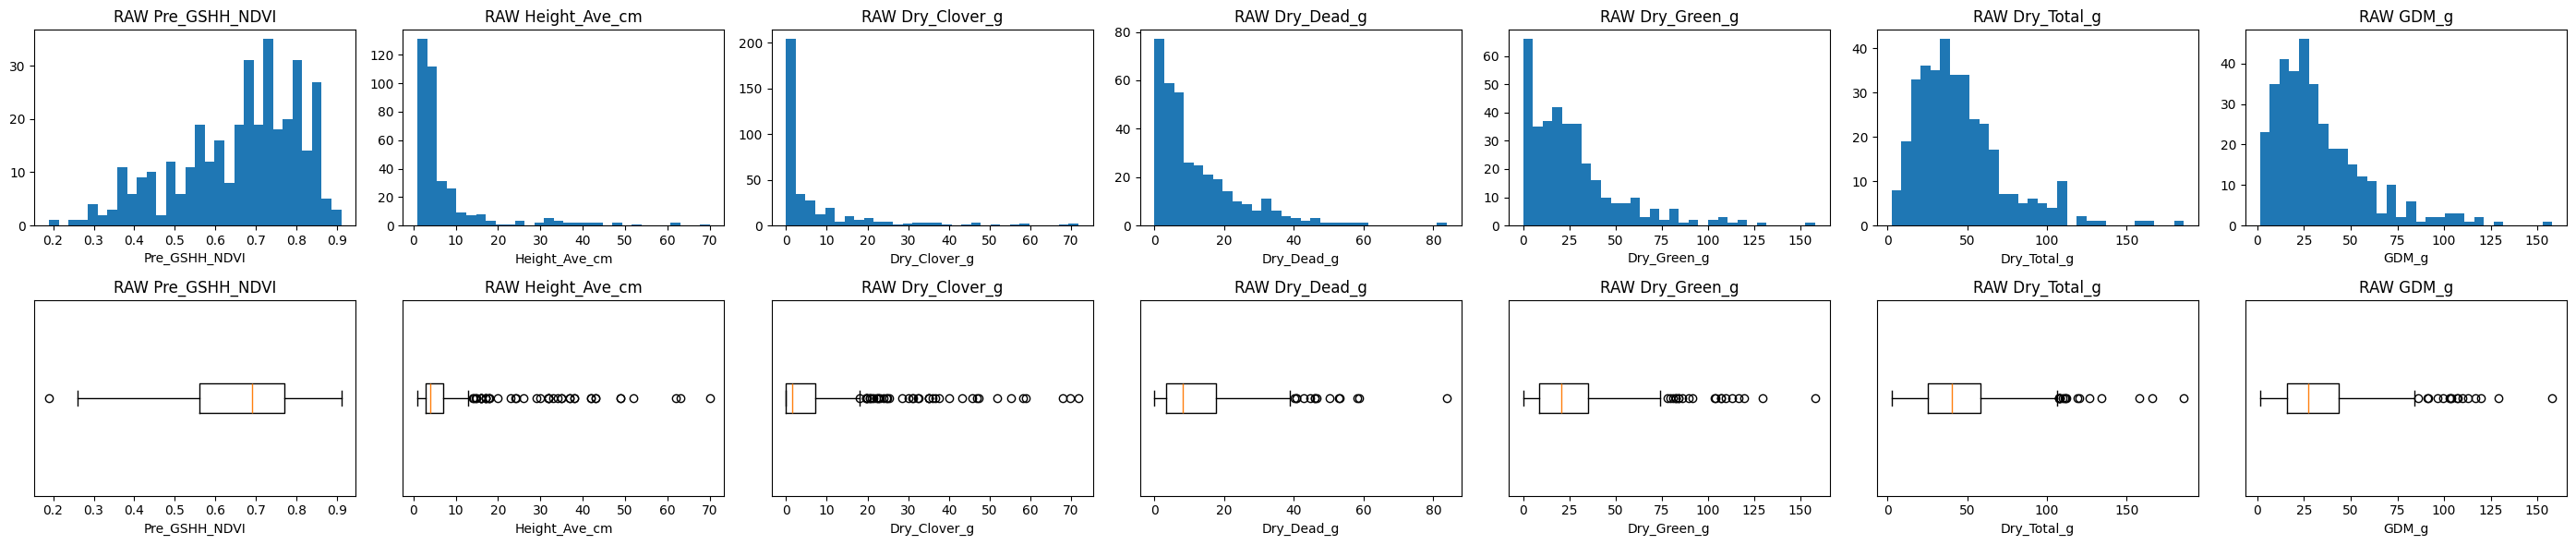

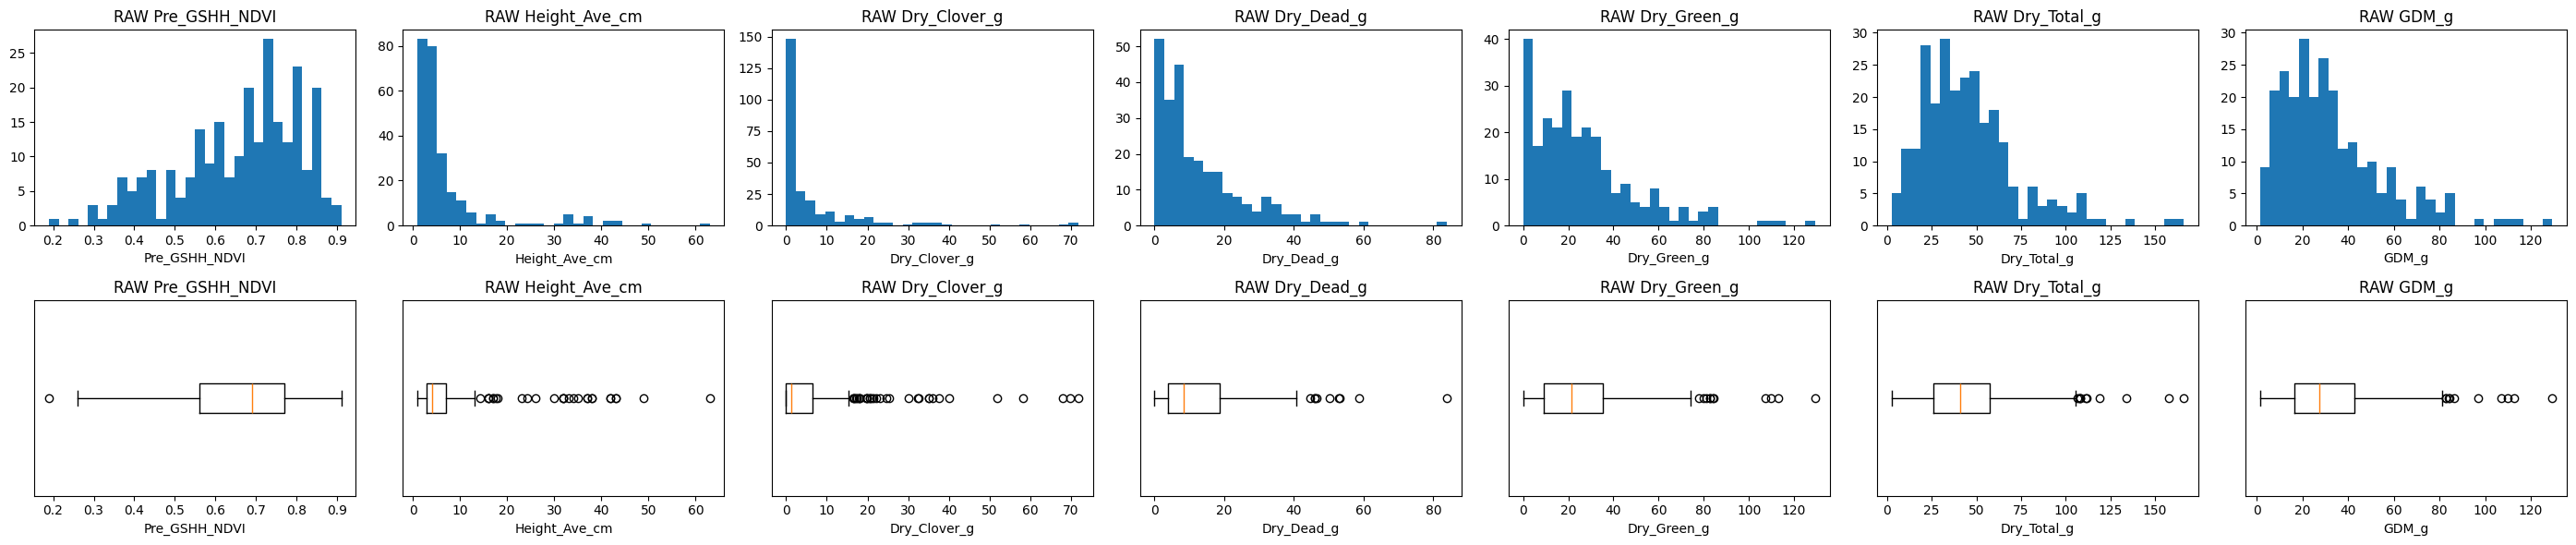

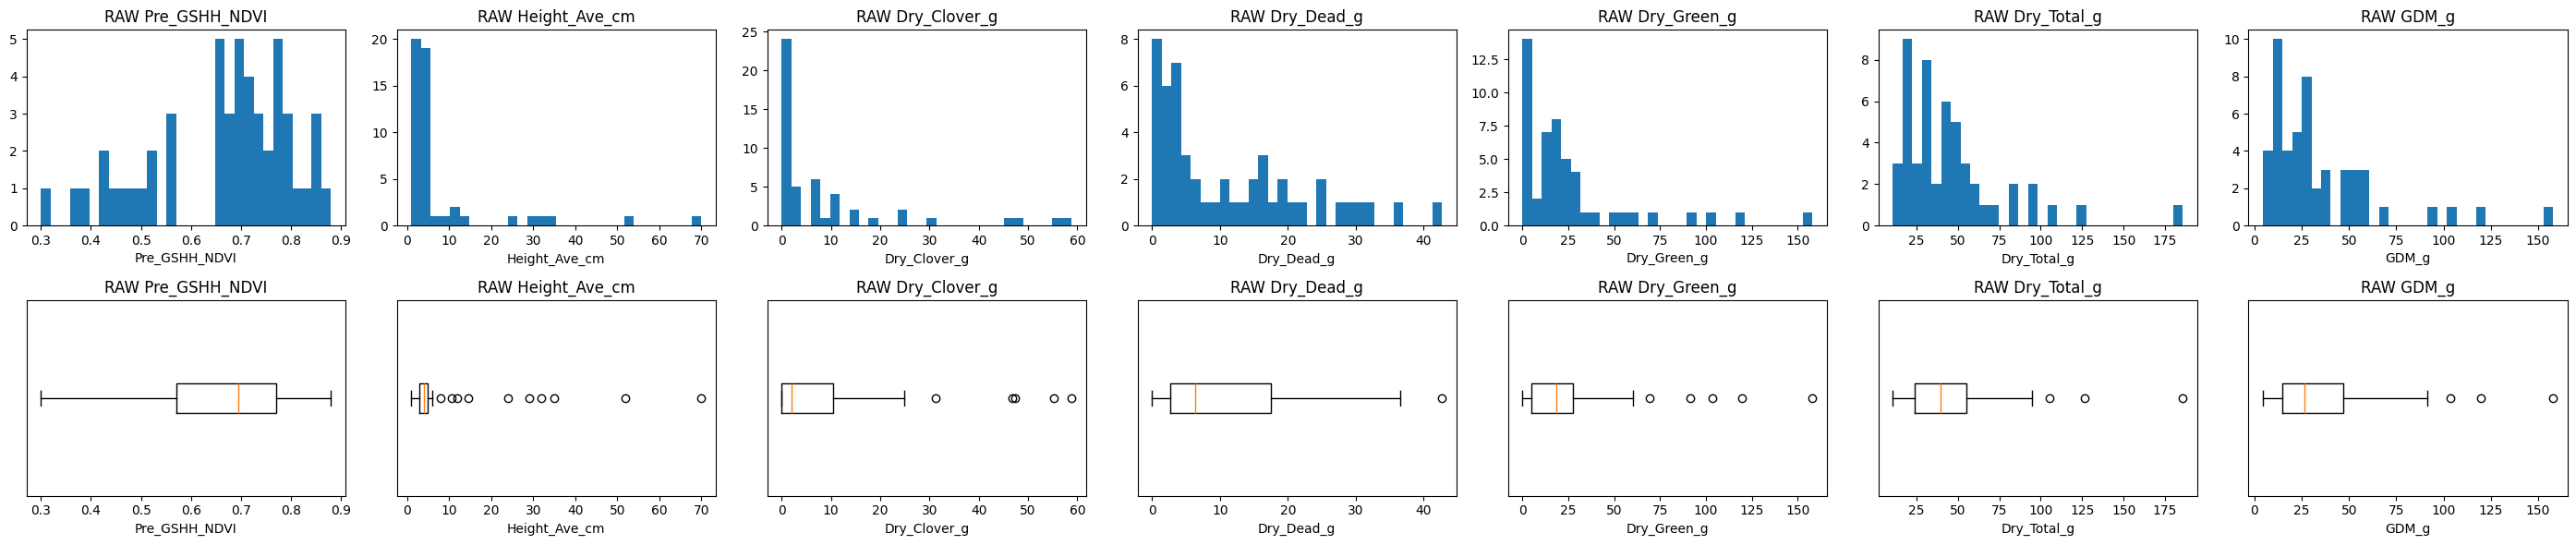

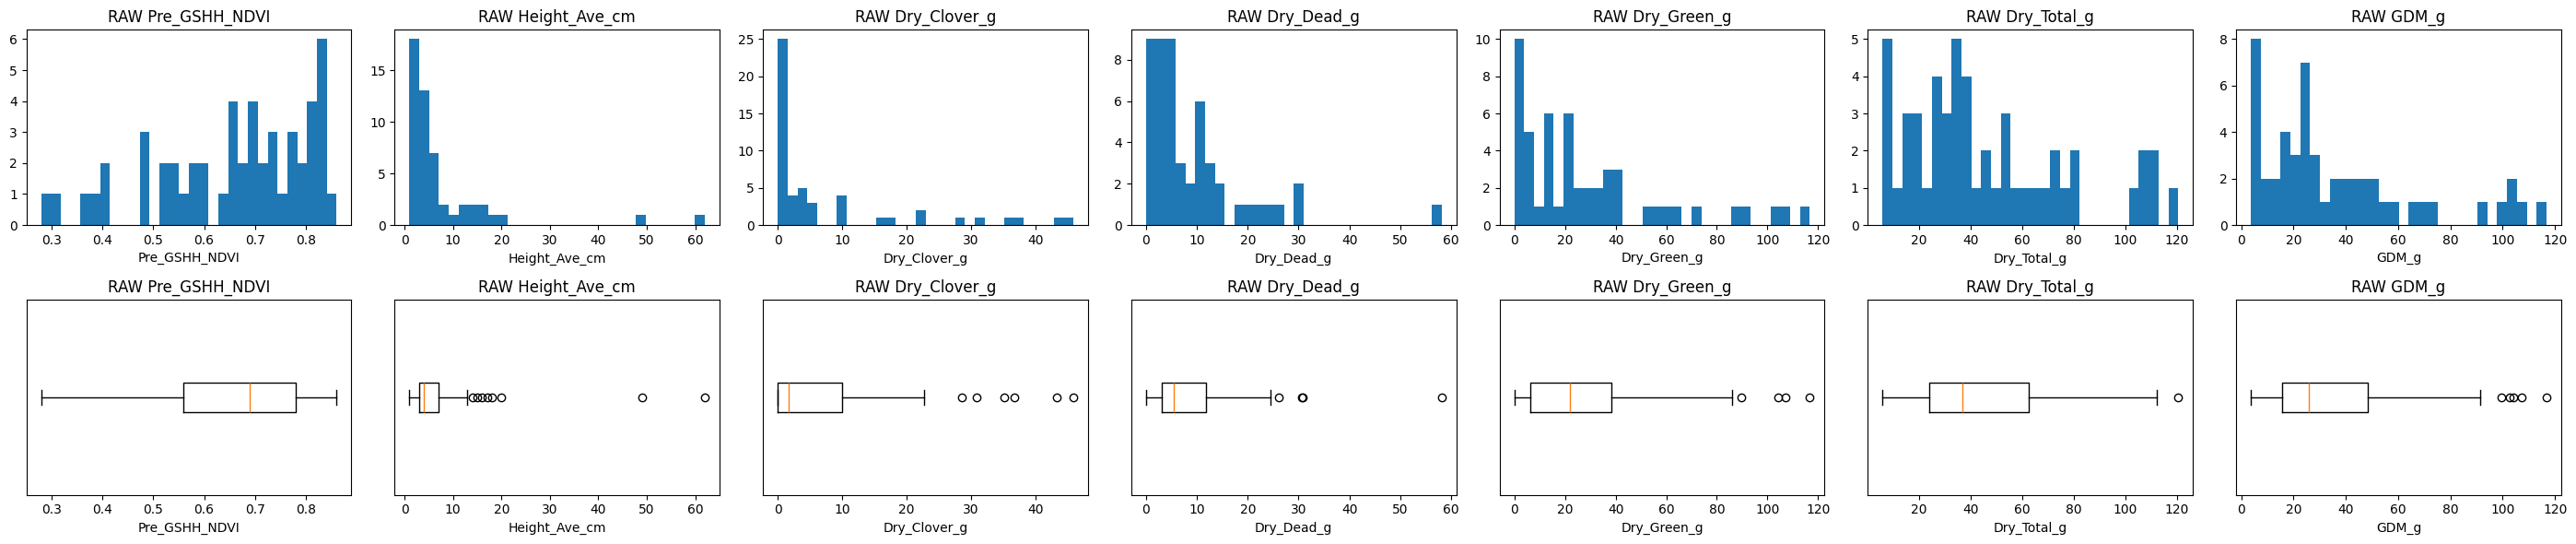

In [80]:
import csiro_biomass_shared_utils as csiro_su


cols = ["Pre_GSHH_NDVI", "Height_Ave_cm",
        "Dry_Clover_g", "Dry_Dead_g",
        "Dry_Green_g", "Dry_Total_g", "GDM_g"]


csiro_su.plot_distributions(full_df, cols)

csiro_su.plot_distributions(train_df, cols)
csiro_su.plot_distributions(val_df, cols)
csiro_su.plot_distributions(test_df, cols)



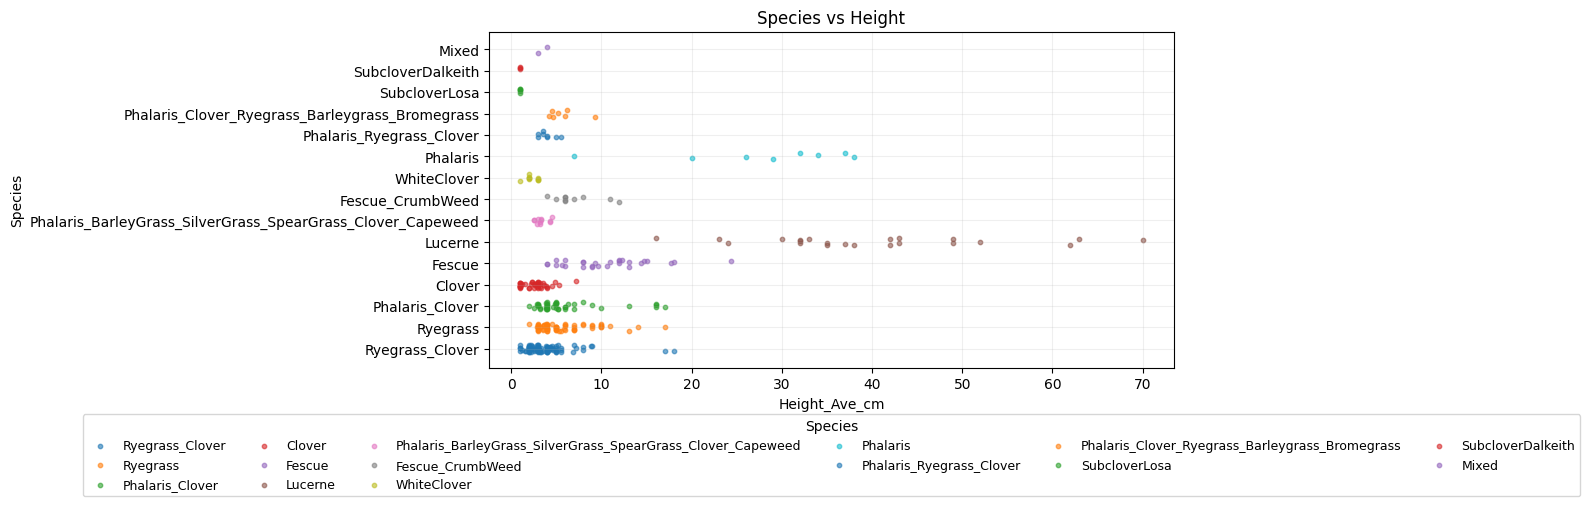

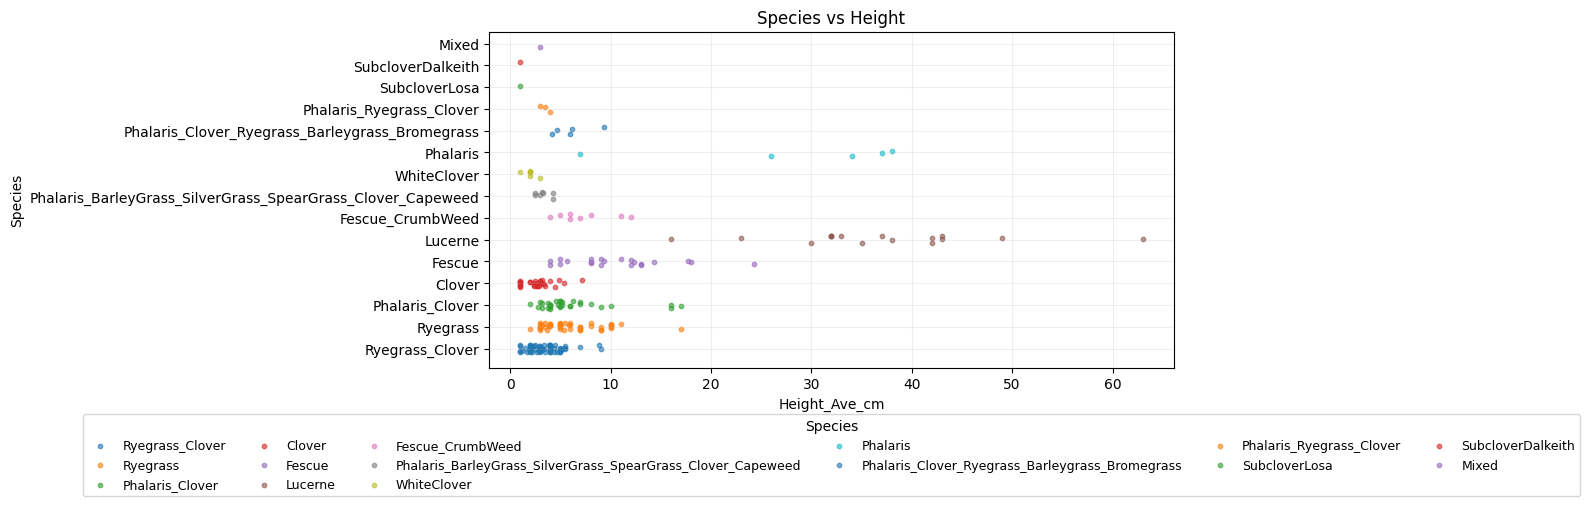

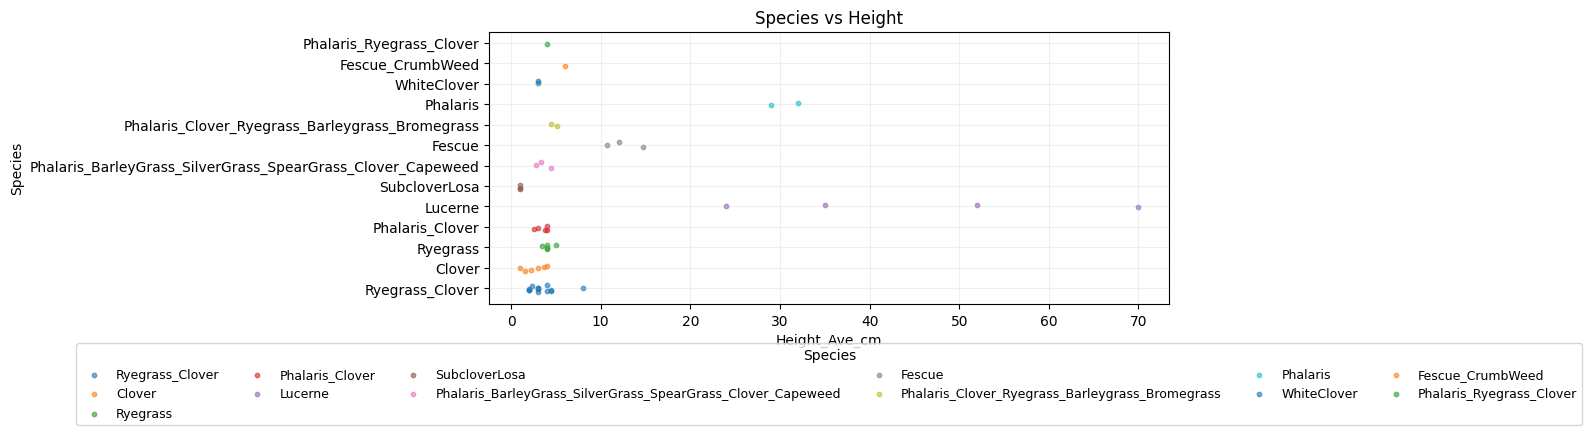

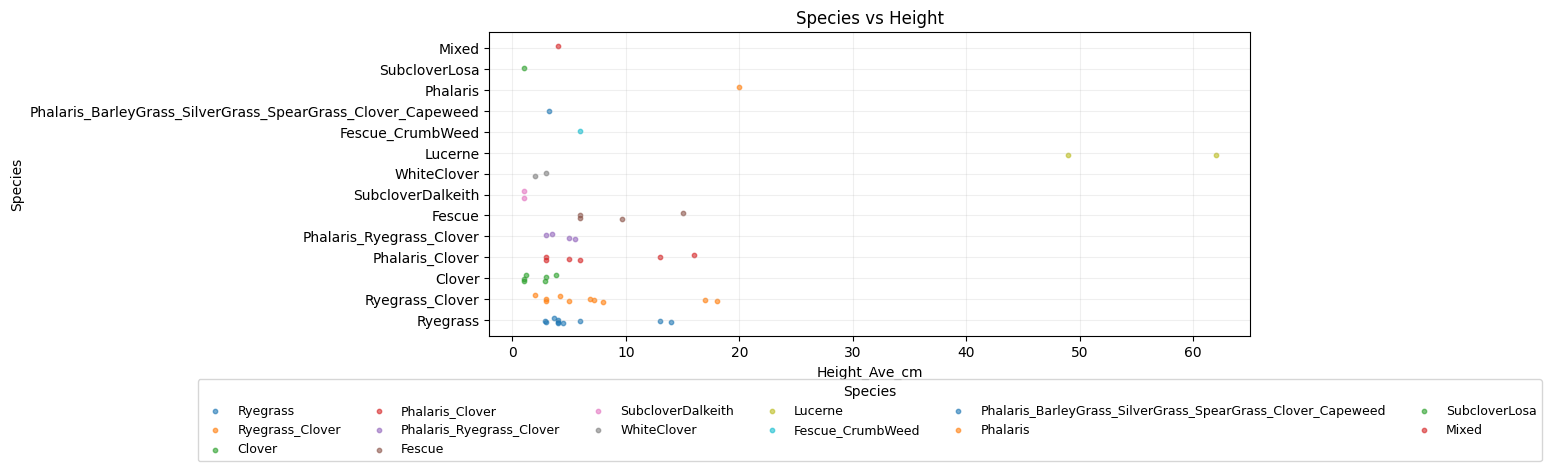

In [81]:
csiro_su.scatter_species_vs_height(full_df, height_col="Height_Ave_cm", species_col="Species", max_points=5000)
csiro_su.scatter_species_vs_height(train_df, height_col="Height_Ave_cm", species_col="Species", max_points=5000)
csiro_su.scatter_species_vs_height(val_df, height_col="Height_Ave_cm", species_col="Species", max_points=5000)
csiro_su.scatter_species_vs_height(test_df, height_col="Height_Ave_cm", species_col="Species", max_points=5000)


In [82]:
import pandas as pd

def tail_check_report(df3, order=("train","val","test")):
    lines = []
    order = list(order)

    def _counts_table(col):
        tbl = df3.groupby("split")[col].value_counts(dropna=False).unstack(fill_value=0)
        # make sure all splits exist
        return tbl.reindex(order).fillna(0).astype(int)

    def _fmt_tbl(tbl, title):
        lines.append(f"{title}")
        lines.append(tbl.to_string())
        lines.append("")

    # ---------------- A1) TailFlag ----------------
    if "TailFlag" in df3.columns:
        tbl_tail = _counts_table("TailFlag")
        _fmt_tbl(tbl_tail, "TailFlag counts per split:")
        tail1 = {s: int(tbl_tail.loc[s].get(1, 0)) for s in order}
    else:
        tbl_tail = None
        tail1 = {s: None for s in order}
        lines.append("TailFlag column missing.\n")

    # ---------------- A2) Bin columns ----------------
    bin_cols = ["Tbin", "Gbin", "Cbin", "Dbin"]
    bin_tbls = {}
    for col in bin_cols:
        if col in df3.columns:
            tbl = _counts_table(col)
            bin_tbls[col] = tbl
            _fmt_tbl(tbl, f"{col} counts per split:")
        else:
            lines.append(f"Missing column: {col}\n")


### A) Tail Check 

In [83]:
order = ["train", "val", "test"]

# A1) TailFlag presence
print("TailFlag counts per split:")
tbl = df3.groupby("split")["TailFlag"].value_counts(dropna=False).unstack(fill_value=0)
print(tbl.reindex(order))

# A2) Tail bins presence (T3/G3/D3)
for col in ["Tbin", "Gbin", "Cbin", "Dbin"]:
    if col in df3.columns:
        print(f"\n{col} counts per split:")
        tbl = df3.groupby("split")[col].value_counts(dropna=False).unstack(fill_value=0)
        print(tbl.reindex(order))
    else:
        print(f"\nMissing column: {col}")


TailFlag counts per split:
TailFlag    0   1
split            
train     230  25
val        44   6
test       44   7

Tbin counts per split:
Tbin    T0  T1  T2  T3
split                 
train  192  39  13  11
val     39   5   4   2
test    36   9   1   5

Gbin counts per split:
Gbin    G0  G1  G2  G3
split                 
train  195  38  14   8
val     36   9   1   4
test    36   6   3   6

Cbin counts per split:
Cbin   C0   C1  C2
split             
train  96  147  12
val    19   26   5
test   20   26   5

Dbin counts per split:
Dbin    D0  D1  D2  D3
split                 
train  187  39  14  15
val     37   9   2   2
test    43   5   2   1


## Summary Report

1. **Resolved Critical Gaps**: All bins across all categories (**T, G, C, D**) now have at least one sample in every split, ensuring no "zero-data" blind spots during testing.
2. **Increased Evaluation Volume**: Your Validation and Test sets have grown to **40+ samples each** (e.g., 40 in val, 41 in test), providing a slightly more statistically significant baseline than your original 28-sample sets.
3. **Balanced Tail Representation**: `TailFlag=1` counts are now nearly identical between Val (6) and Test (7), making your evaluation metrics more comparable across these two sets.
4. **Stable "Hard Case" Coverage**: The most extreme bins—**T3 (hardest NDVI)**, **G3 (hardest green)**, and **D3 (hardest dead)**—all have 3 to 6 samples in the evaluation sets, which is sufficient for a robustness check.
5. **Mid-Bin Consistency**: The previously problematic **G2 bin** is now consistently represented with 2 samples in Val and 2 in Test, allowing for more reliable mid-range performance tracking.
6. **Cbin Stability**: Cloud/Cover (Cbin) remains your most balanced feature, with **C0** and **C1** showing very healthy distributions across all three splits.
7. **Dbin Evaluation Bias**: In the Test set, **D0** is very high (34) compared to D1–D3 (only 7 total). This means your Test performance for the "Dead" category will be dominated by the 0-index bin.
8. **Training Concentration**: The training set remains heavily weighted toward the 0-index bins (e.g., 209 samples in T0 vs. 10 in T3), which is standard for long-tail datasets but requires careful sampling.
9. **Improved Tail Proportion**: The tail rate in Val/Test is now ~15–17%, which is much closer to the Train rate (~9%) than in previous iterations, reducing the "pessimistic bias" in evaluation scores.
10. **Final Verdict**: This is your **most robust split yet**. It balances the need for comprehensive bin coverage with the reality of a small total sample size.

### B) Clover Regime Check

In [84]:
order = ["train", "val", "test"]

print("Cbin counts per split (train/val/test):")
c = df3.groupby("split")["Cbin"].value_counts(dropna=False).unstack(fill_value=0)
c = c.reindex(order)

# optional: order columns if they exist
cols_order = [x for x in ["C0", "C1", "C2"] if x in c.columns]
if cols_order:
    c = c[cols_order]

print(c)

Cbin counts per split (train/val/test):
Cbin   C0   C1  C2
split             
train  96  147  12
val    19   26   5
test   20   26   5


1. **Must-have coverage is satisfied (B passes):** every split contains both **C0** and **C2**.

   * Train: C0=114, C2=20
   * Val: C0=12, C2=1
   * Test: C0=9, C2=1

2. **Train has healthy representation of all clover regimes:** C0 (zeros), C1 (non-tail non-zero), and C2 (non-zero tail) are all present with decent counts (114/165/20), so the model will actually learn clover behavior across regimes.

3. **Val/Test have *very thin* C2 coverage (only 1 sample each):** this meets the rule, but it means any evaluation that’s sensitive to clover tail behavior will be **high variance**—one row can swing results.

4. **Most val/test samples sit in C0/C1, not C2:** Val has 29/30 in C0/C1; Test has 26/27 in C0/C1. So your validation/test performance will mostly reflect performance on “normal” clover regimes, with only a tiny check on the tail.

5. **Practical takeaway:** keep C2 in the split (good), but don’t over-interpret clover-tail performance from val/test; if clover tail matters to your final score, rely more on train diagnostics (or CV / repeated splits) rather than a single 1-sample tail in val/test.


### C) Species Coverage Check

In [85]:
# summaries: dict like {"full": df_summary, "train": df_summary, ...}
# each df_summary has a column named "col" + metric columns
cols = [
    "Pre_GSHH_NDVI", "Height_Ave_cm", "Dry_Clover_g", "Dry_Dead_g",
    "Dry_Green_g", "Dry_Total_g", "GDM_g"
]

weights = {
    "Dry_Green_g": 0.1,
    "Dry_Dead_g":  0.1,
    "Dry_Clover_g":0.1,
    "GDM_g":       0.2,
    "Dry_Total_g": 0.5,
    # others will use default_weight=1.0
}

datasets = {
    "full": full_df,
    "train": train_df,
    "val": val_df,
    "test": test_df,
}

summaries = {
    name: csiro_su.strong_points_from_distributions(
        df,
        cols=cols,
        bands=(8, 20),
        tail_frac=0.10,
        weights=weights,
        default_weight=1.0,
        dropna=True,
        top_by="sst",     # or "value"
    )
    for name, df in datasets.items()
}

long = (
    pd.concat(
        {name: s.set_index("col") for name, s in summaries.items()},
        names=["dataset", "col"]   # <- creates a clean 2-level row index
    )
    .sort_index(level=["col", "dataset"])  # <- groups rows by feature (full/train/val/test)
)

dataset_order = ["full", "train", "val", "test"]
# dataset_order = ["full", "train", "val"]

# if your table currently has a MultiIndex (dataset, col) like in the screenshot:
ordered = long.reset_index()

ordered["dataset"] = pd.Categorical(ordered["dataset"], categories=dataset_order, ordered=True)
ordered["col"]     = pd.Categorical(ordered["col"],     categories=cols,          ordered=True)

ordered = ordered.sort_values(["col", "dataset"]).set_index(["dataset", "col"])
ordered



,,n,weight,mean,std,var,cv,pct_zero,min,q10,q25,median,q75,q90,q95,q99,max,top_tail_weighted_sst_share_pct,pct_in_0_8,pct_in_0_20
dataset,col,,,,,,,,,,,,,,,,,,,
full,Pre_GSHH_NDVI,356,1.0,0.658820,0.150045,0.022514,0.227748,0.000000,0.1900,0.42000,0.560000,0.69000,0.770000,0.83000,0.860000,0.874500,0.9100,41.648920,100.000000,100.000000
train,Pre_GSHH_NDVI,255,1.0,0.658157,0.151362,0.022910,0.229978,0.000000,0.1900,0.42000,0.560000,0.69000,0.770000,0.84000,0.860000,0.879200,0.9100,41.341136,100.000000,100.000000
val,Pre_GSHH_NDVI,50,1.0,0.664600,0.142072,0.020185,0.213771,0.000000,0.3000,0.43900,0.570000,0.69500,0.770000,0.81200,0.850000,0.870200,0.8800,42.624863,100.000000,100.000000
test,Pre_GSHH_NDVI,51,1.0,0.656471,0.153751,0.023639,0.234208,0.000000,0.2800,0.41000,0.560000,0.69000,0.780000,0.83000,0.840000,0.850000,0.8600,46.755007,100.000000,100.000000
full,Height_Ave_cm,356,1.0,7.614513,10.293771,105.961713,1.351862,0.000000,1.0000,2.00000,3.000000,4.00000,7.000000,16.00000,32.250000,50.350000,70.0000,84.698451,79.494382,92.134831
train,Height_Ave_cm,255,1.0,7.434640,9.476295,89.800171,1.274614,0.000000,1.0000,2.00000,3.000000,4.00000,7.000000,16.00000,32.300000,43.000000,63.0000,84.213636,79.215686,92.156863
val,Height_Ave_cm,50,1.0,8.341336,13.405904,179.718258,1.607165,0.000000,1.0000,1.95000,3.000000,4.00000,4.875000,24.50000,33.650000,61.180000,70.0000,84.089295,82.000000,88.000000
test,Height_Ave_cm,51,1.0,7.801308,10.922021,119.290534,1.400024,0.000000,1.0000,1.16670,3.000000,4.00000,7.000000,16.00000,19.000000,55.500000,62.0000,84.490969,78.431373,96.078431
full,Dry_Clover_g,356,0.1,6.667416,12.130181,147.141303,1.819323,37.921348,0.0000,0.00000,0.000000,1.42940,7.262175,20.31565,33.228450,58.583000,71.7865,78.292316,76.404494,89.887640


### Key species by frequency (top-K + “must appear”)

In [86]:
def species_coverage_topk(full_df, train_df, val_df, test_df, species_col="Species", top_k=6):
    top_species = full_df[species_col].value_counts().head(top_k).index.tolist()
    splits = {"train": train_df, "val": val_df, "test": test_df}

    print("Top species (by full freq):", top_species)
    for sname, sdf in splits.items():
        present = set(sdf[species_col].unique())
        missing = [sp for sp in top_species if sp not in present]
        print(f"{sname}: missing top species -> {missing}")

species_coverage_topk(full_df, train_df, val_df, test_df, top_k=10)
# species_coverage_topk(full_df, train_df, val_df, top_k=7)


Top species (by full freq): ['Ryegrass_Clover', 'Ryegrass', 'Phalaris_Clover', 'Clover', 'Fescue', 'Lucerne', 'Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed', 'Fescue_CrumbWeed', 'WhiteClover', 'Phalaris']
train: missing top species -> []
val: missing top species -> []
test: missing top species -> []


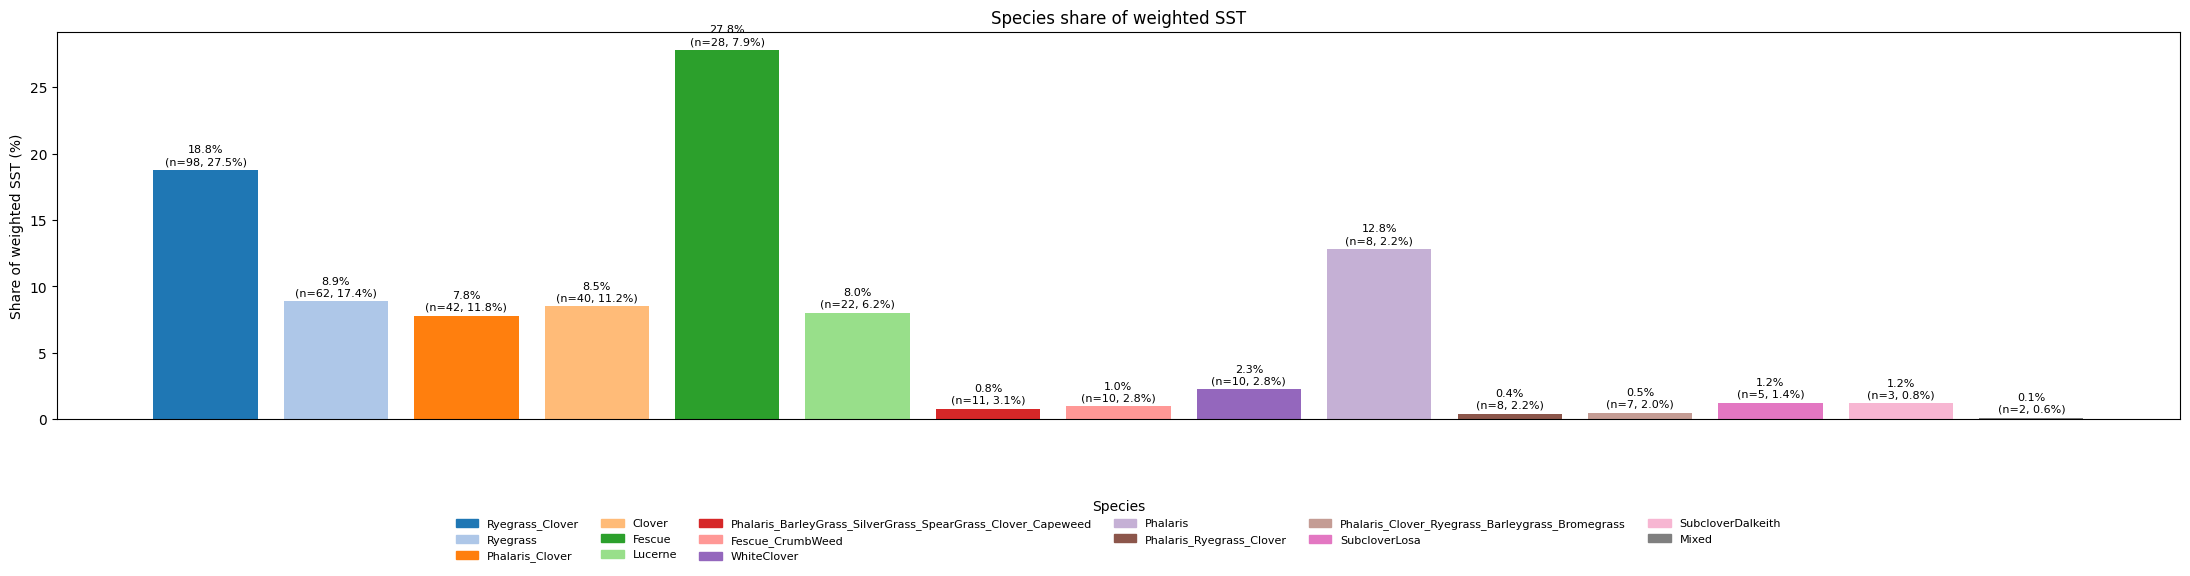

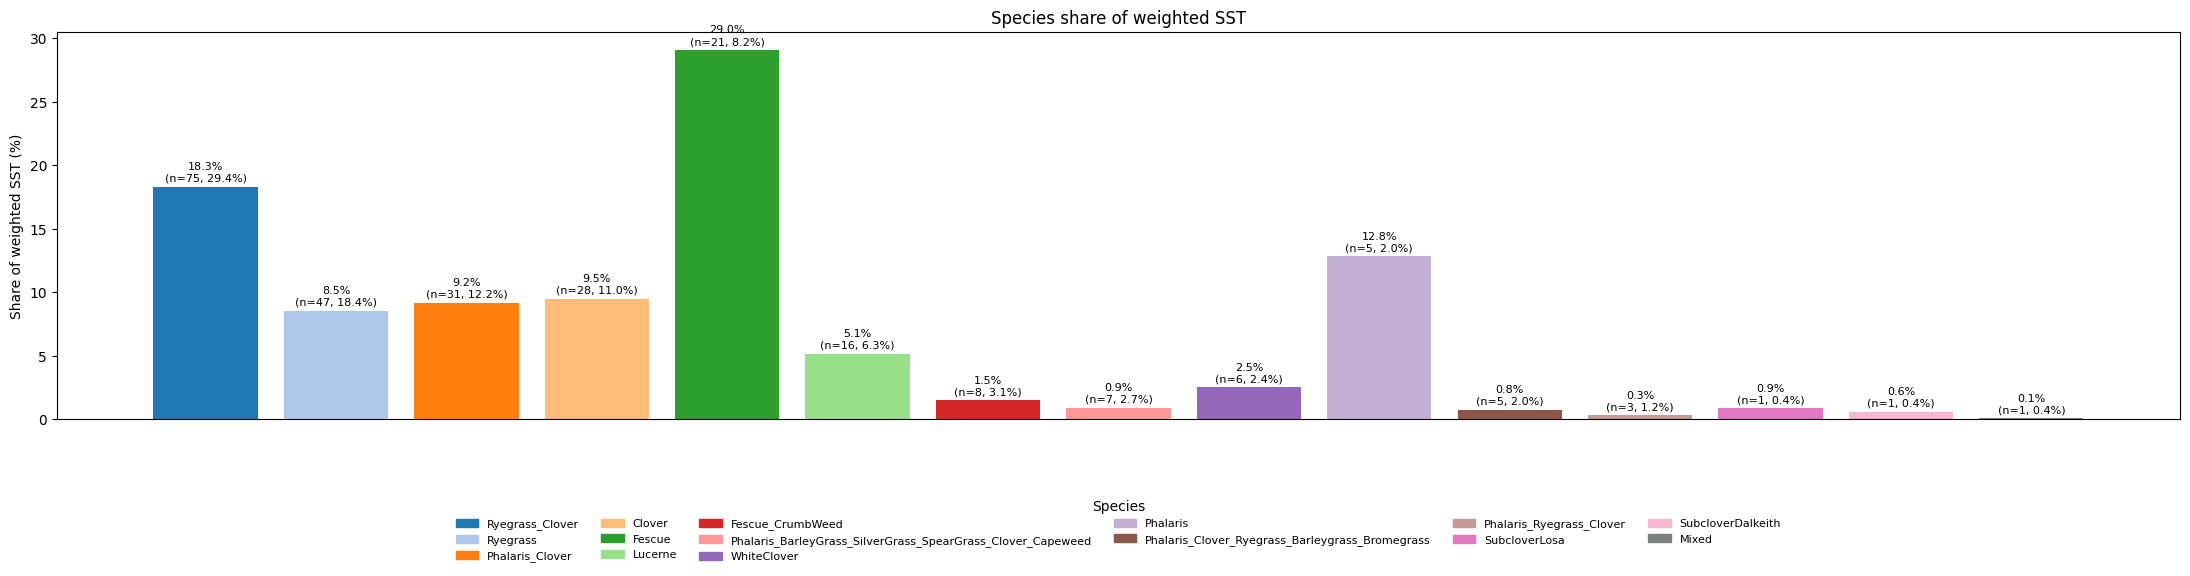

In [87]:
_ = csiro_su.plot_species_sst_sse_share(full_df, yhat_df=None)

_ = csiro_su.plot_species_sst_sse_share(train_df, yhat_df=None)

In [88]:
import numpy as np
import pandas as pd

def species_weighted_sst_share(
    df: pd.DataFrame,
    species_col: str = "Species",
    target_cols=("Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"),
    target_weights=None,
    dropna: bool = True,
):
    """
    Returns dict:
      {
        "<species_name>": {"n": <int>, "share_wsst": <float percent>}
      }

    share_wsst is % share of the weighted SST across target_cols.

    Notes:
    - Uses global mean per target (same baseline as SST definition).
    - If dropna=True: drops rows with any NaN in [species_col]+target_cols.
    """

    if target_weights is None:
        target_weights = np.ones(len(target_cols), dtype=np.float64)
    else:
        target_weights = np.asarray(target_weights, dtype=np.float64)
        if target_weights.shape[0] != len(target_cols):
            raise ValueError("target_weights must have same length as target_cols")

    cols = [species_col] + list(target_cols)
    d = df[cols].copy()

    if dropna:
        d = d.dropna(subset=cols)

    # numeric targets
    Y = d[list(target_cols)].astype(float).to_numpy()  # (N,K)
    w = target_weights.reshape(1, -1)                  # (1,K)

    # global mean per target (SST baseline)
    mu = np.nanmean(Y, axis=0, keepdims=True)          # (1,K)
    dev2 = (Y - mu) ** 2                               # (N,K)

    # total weighted SST
    total_wsst = np.sum(dev2 * w)
    if not np.isfinite(total_wsst) or total_wsst <= 1e-12:
        # degenerate case (all targets constant)
        out = {}
        for sp, sub in d.groupby(species_col):
            out[str(sp)] = {"n": int(len(sub)), "share_wsst": float("nan")}
        return out

    out = {}
    for sp, idx in d.groupby(species_col).groups.items():
        idx = np.asarray(list(idx))
        sp_wsst = np.sum(dev2[idx, :] * w)             # scalar
        share_pct = 100.0 * sp_wsst / total_wsst
        out[str(sp)] = {"n": int(len(idx)), "share_wsst": float(share_pct)}

    return out


In [89]:
BIOMASS_COLS = ["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"]
BIOMASS_W    = [0.1, 0.1, 0.1, 0.5, 0.2]

d = species_weighted_sst_share(
    full_df,
    species_col="Species",
    target_cols=BIOMASS_COLS,
    target_weights=BIOMASS_W
)

# d["Lucerne"] -> {"n": ..., "share_wsst": ...}
d_sorted = dict(sorted(d.items(), key=lambda kv: kv[1]["share_wsst"], reverse=True))

print(d_sorted)

import pandas as pd

# d_sorted: dict {species: {"n": int, "share_wsst": float}}

df_species = (
    pd.DataFrame.from_dict(d_sorted, orient="index")   # index = species
      .reset_index()
      .rename(columns={"index": "Species", "share_wsst": "Share_wSST_%", "n": "n"})
      .sort_values("Share_wSST_%", ascending=False)
      .reset_index(drop=True)
)

# df_species

df_species.style.format({"Share_wSST_%": "{:.2f}"})


{'Fescue': {'n': 28, 'share_wsst': 27.782566867636206}, 'Ryegrass_Clover': {'n': 98, 'share_wsst': 18.757733546032522}, 'Phalaris': {'n': 8, 'share_wsst': 12.810611436042606}, 'Ryegrass': {'n': 62, 'share_wsst': 8.88062381056966}, 'Clover': {'n': 40, 'share_wsst': 8.504871536282858}, 'Lucerne': {'n': 22, 'share_wsst': 7.995328159529521}, 'Phalaris_Clover': {'n': 42, 'share_wsst': 7.802255586803082}, 'WhiteClover': {'n': 10, 'share_wsst': 2.2535257075385244}, 'SubcloverLosa': {'n': 5, 'share_wsst': 1.227696459448081}, 'SubcloverDalkeith': {'n': 3, 'share_wsst': 1.2085436246972159}, 'Fescue_CrumbWeed': {'n': 10, 'share_wsst': 0.9846525444190596}, 'Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed': {'n': 11, 'share_wsst': 0.7799919422521269}, 'Phalaris_Clover_Ryegrass_Barleygrass_Bromegrass': {'n': 7, 'share_wsst': 0.4852074705613035}, 'Phalaris_Ryegrass_Clover': {'n': 8, 'share_wsst': 0.4225972637830379}, 'Mixed': {'n': 2, 'share_wsst': 0.10379404440419772}}


,Species,n,Share_wSST_%
0,Fescue,28,27.78
1,Ryegrass_Clover,98,18.76
2,Phalaris,8,12.81
3,Ryegrass,62,8.88
4,Clover,40,8.50
5,Lucerne,22,8.00
6,Phalaris_Clover,42,7.80
7,WhiteClover,10,2.25
8,SubcloverLosa,5,1.23
9,SubcloverDalkeith,3,1.21


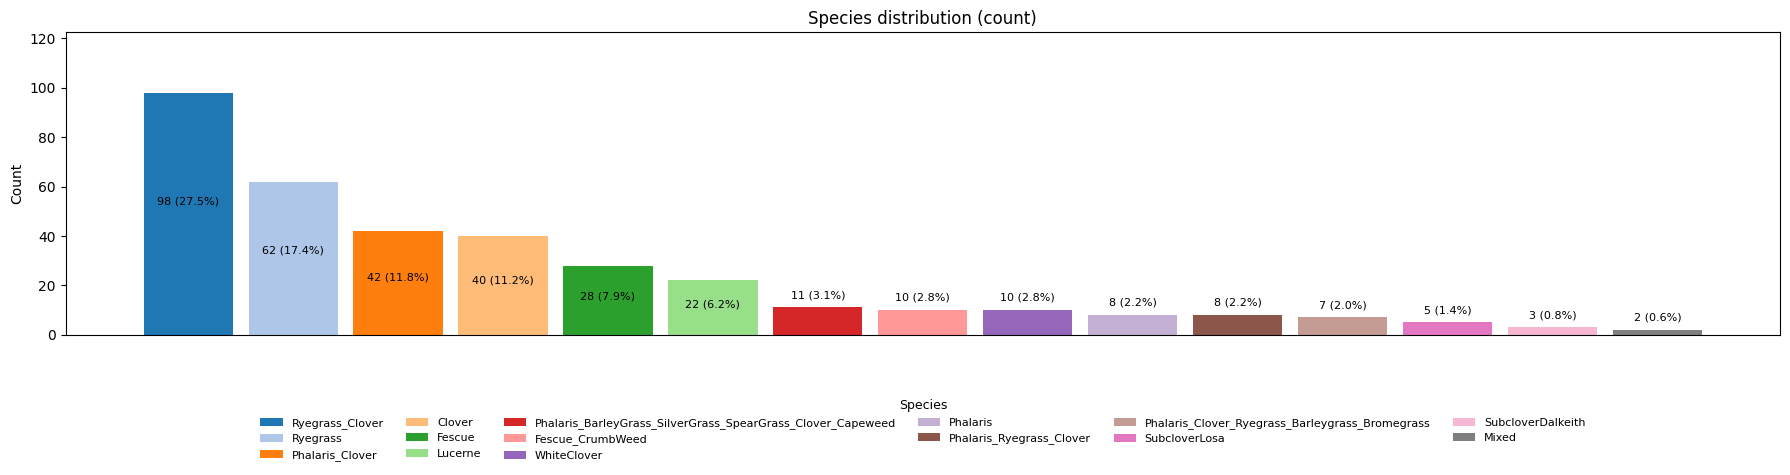

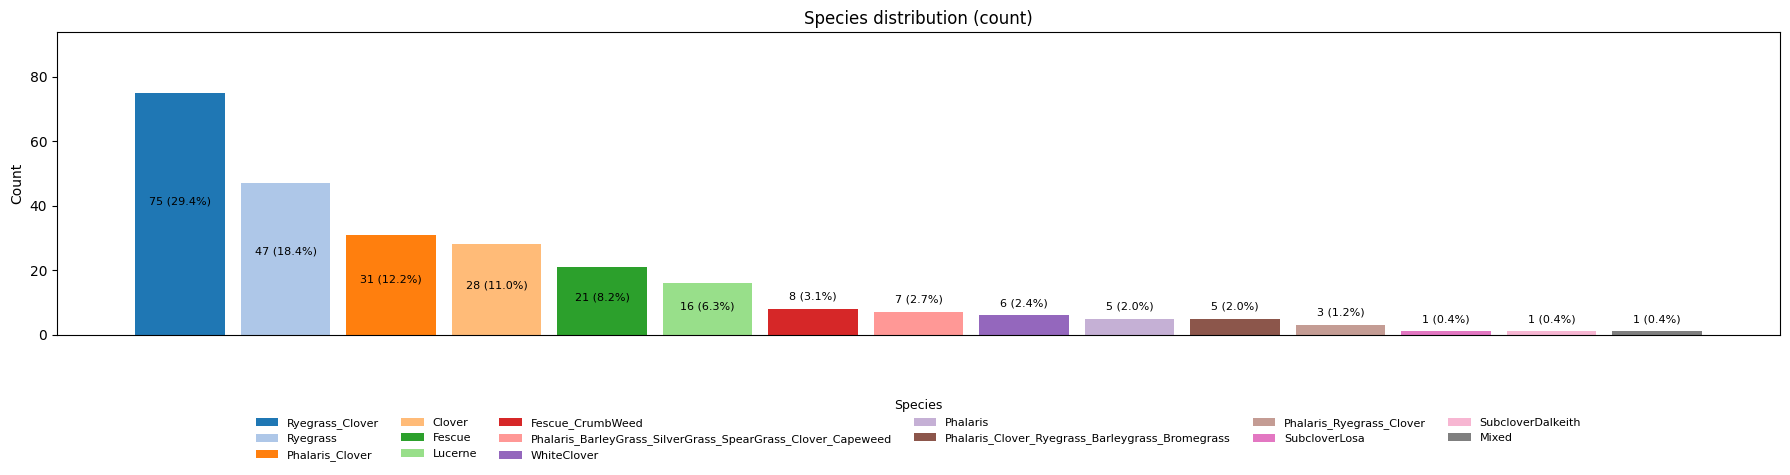

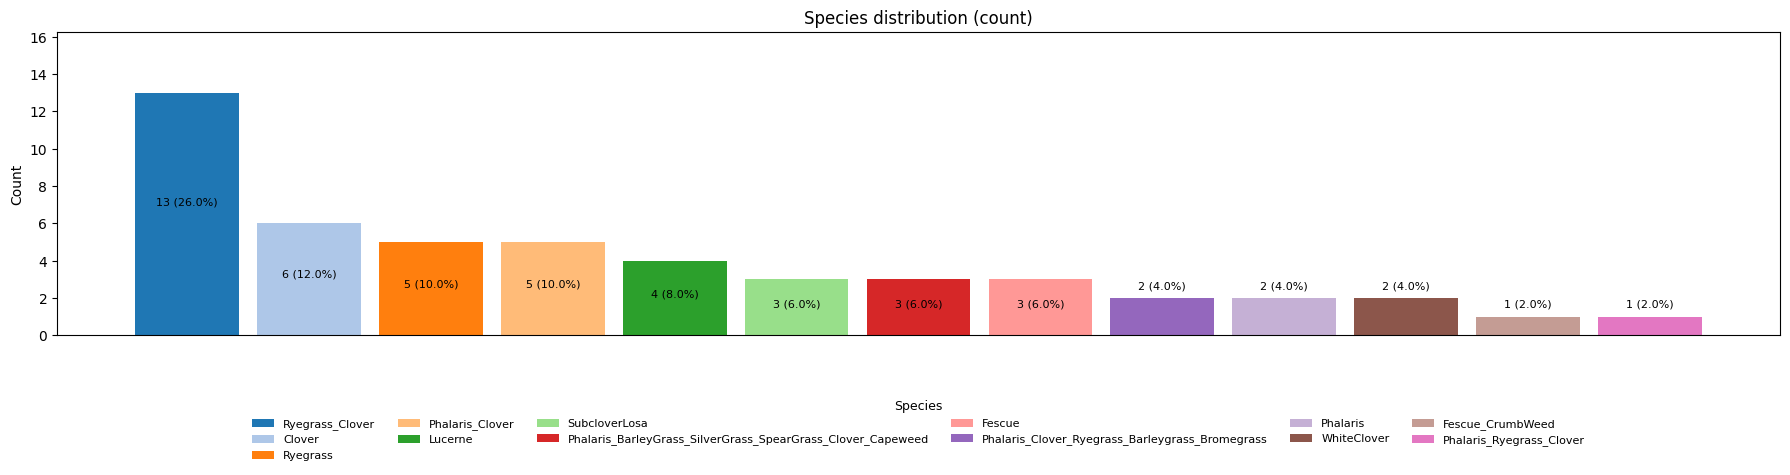

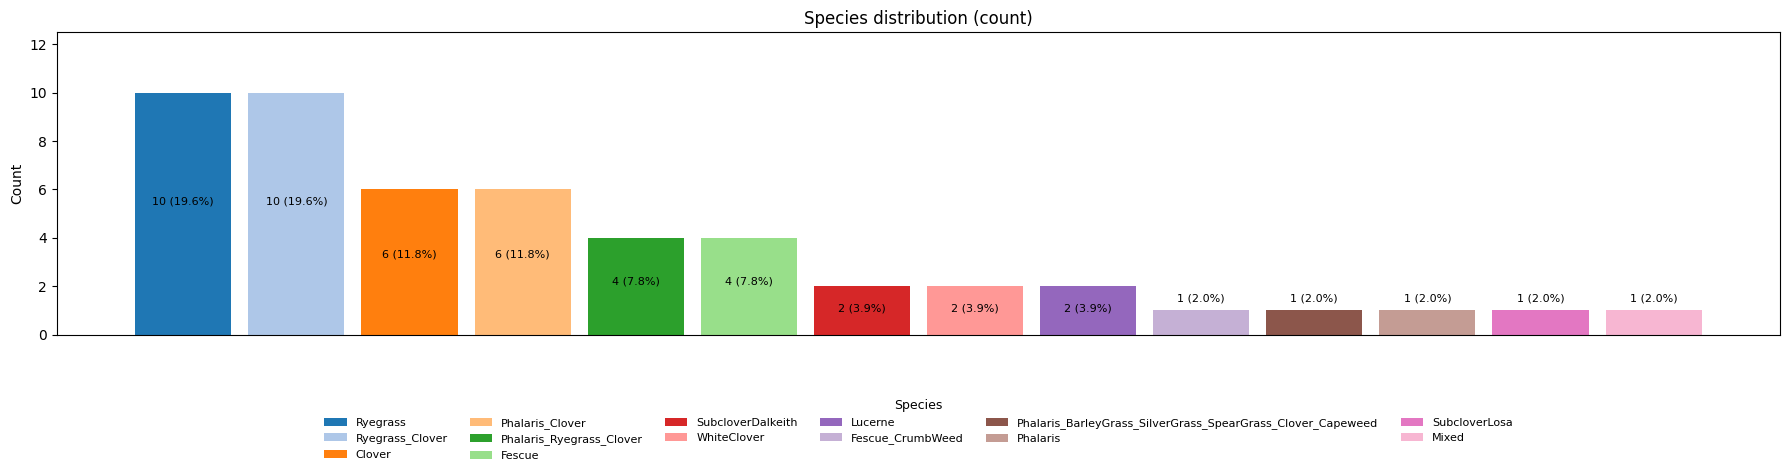

In [90]:
# usage
counts, pct = csiro_su.species_distribution_count(full_df)

counts, pct = csiro_su.species_distribution_count(train_df)

counts, pct = csiro_su.species_distribution_count(val_df)

counts, pct = csiro_su.species_distribution_count(test_df)

/tmp/ipykernel_25847/942026903.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


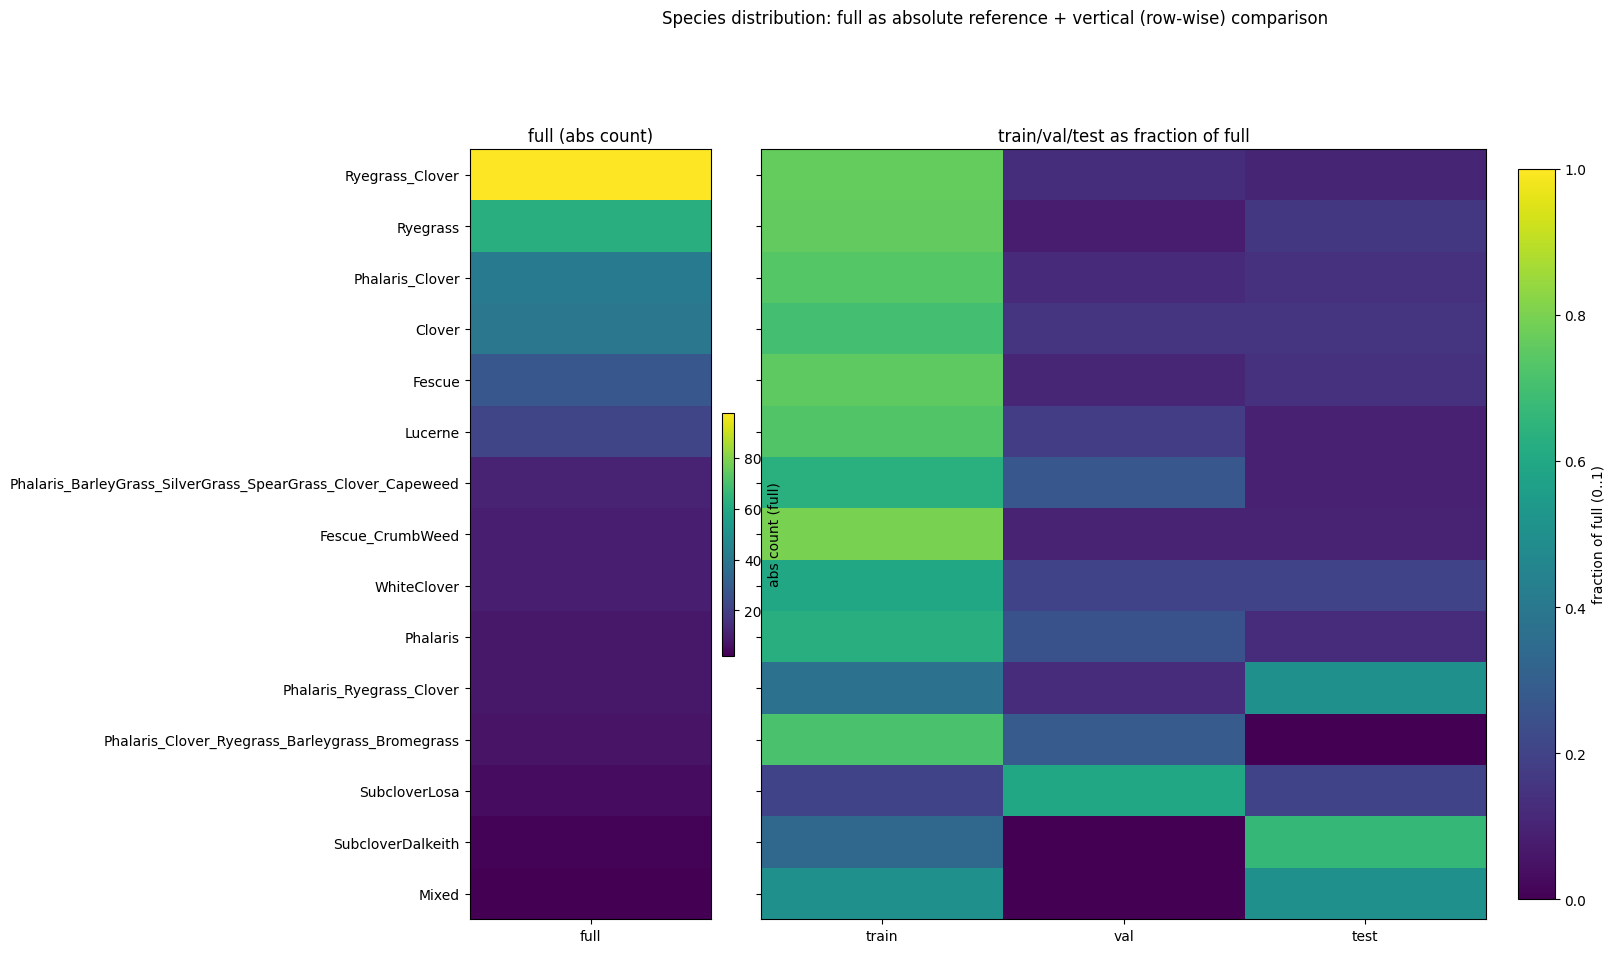

,full,train,val,test
Species,,,,
Ryegrass_Clover,98,75,13,10
Ryegrass,62,47,5,10
Phalaris_Clover,42,31,5,6
Clover,40,28,6,6
Fescue,28,21,3,4
Lucerne,22,16,4,2
Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed,11,7,3,1
Fescue_CrumbWeed,10,8,1,1
WhiteClover,10,6,2,2


,full,train,val,test
Species,,,,
Ryegrass_Clover,98.0,0.765,0.133,0.102
Ryegrass,62.0,0.758,0.081,0.161
Phalaris_Clover,42.0,0.738,0.119,0.143
Clover,40.0,0.700,0.150,0.150
Fescue,28.0,0.750,0.107,0.143
Lucerne,22.0,0.727,0.182,0.091
Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed,11.0,0.636,0.273,0.091
Fescue_CrumbWeed,10.0,0.800,0.100,0.100
WhiteClover,10.0,0.600,0.200,0.200


In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def species_dist_compare_vertical_ref(
    full_df, train_df, val_df, test_df=None,
    species_col="Species",
    top_k=None,
    figsize=(14, 10),
):
    dfs = {"full": full_df, "train": train_df, "val": val_df}
    if test_df is not None:
        dfs["test"] = test_df

    # counts per split
    counts = {k: df[species_col].value_counts(dropna=False) for k, df in dfs.items()}

    # align rows to FULL ordering
    all_species = counts["full"].index
    mat = pd.concat([counts[k].reindex(all_species, fill_value=0) for k in dfs.keys()], axis=1)
    mat.columns = list(dfs.keys())

    if top_k is not None:
        mat = mat.iloc[:top_k]

    # --- Build reference + fractions ---
    full_counts = mat["full"].astype(float)
    frac = mat.copy().astype(float)
    for c in frac.columns:
        if c != "full":
            frac[c] = np.where(full_counts.values > 0, frac[c].values / full_counts.values, 0.0)

    # Split into: full absolute (1 col) and split fractions (N-1 cols)
    split_cols = [c for c in mat.columns if c != "full"]
    full_abs = mat[["full"]].values.astype(float)         # (R,1)
    split_frac = frac[split_cols].values.astype(float)    # (R,K)

    # --- Plot ---
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 2, width_ratios=[1, len(split_cols)], wspace=0.05)

    ax0 = fig.add_subplot(gs[0, 0])  # full absolute
    ax1 = fig.add_subplot(gs[0, 1])  # fractions

    # FULL absolute colors (your reference)
    im0 = ax0.imshow(full_abs, aspect="auto")
    ax0.set_title("full (abs count)")
    ax0.set_xticks([0])
    ax0.set_xticklabels(["full"])
    ax0.set_yticks(range(len(mat.index)))
    ax0.set_yticklabels(mat.index)

    # FRACTIONS relative to full (vertical comparison)
    im1 = ax1.imshow(split_frac, aspect="auto", vmin=0.0, vmax=1.0)
    ax1.set_title("train/val/test as fraction of full")
    ax1.set_xticks(range(len(split_cols)))
    ax1.set_xticklabels(split_cols)
    ax1.set_yticks(range(len(mat.index)))
    ax1.set_yticklabels([])  # share labels from left

    # Colorbars
    cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)
    cbar0.set_label("abs count (full)")

    cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label("fraction of full (0..1)")

    plt.suptitle("Species distribution: full as absolute reference + vertical (row-wise) comparison", y=1.02)
    plt.tight_layout()
    plt.show()

    # return both tables (useful)
    return mat.astype(int), frac.round(3)

counts_mat, frac_mat = species_dist_compare_vertical_ref(
    full_df, train_df, val_df, test_df,
    species_col="Species",
    top_k=20,
    figsize=(14,10)
)

display(counts_mat)
display(frac_mat)



#### High-impact species buckets (based on RowImpact tail)

In [92]:
import numpy as np

WEIGHTS = {
    "Dry_Total_g": 0.5,
    "GDM_g": 0.2,
    "Dry_Dead_g": 0.1,
    "Dry_Green_g": 0.1,
    "Dry_Clover_g": 0.1,
}

def ensure_rowimpact(train_df, val_df, test_df, impact_col="RowImpact", weights=WEIGHTS):
    # If already present, do nothing
    if impact_col in train_df.columns and impact_col in val_df.columns and impact_col in test_df.columns:
        return train_df, val_df, test_df

    # compute mu from TRAIN only (no leakage)
    req = list(weights.keys())
    missing = [c for c in req if c not in train_df.columns]
    if missing:
        raise KeyError(f"Can't compute {impact_col}. Missing columns in train_df: {missing}")

    mu = train_df[req].mean()

    def compute(df):
        s = 0.0
        for c, w in weights.items():
            s = s + w * (df[c] - mu[c])**2
        df = df.copy()
        df[impact_col] = s
        return df

    return compute(train_df), compute(val_df), compute(test_df)

def species_coverage_highimpact(train_df, val_df, test_df,
                               species_col="Species", impact_col="RowImpact",
                               tail=0.10, top_n=8):
    thr = train_df[impact_col].quantile(1 - tail)
    hi_train = train_df[train_df[impact_col] >= thr]
    hi_species = hi_train[species_col].value_counts().head(top_n).index.tolist()

    print(f"High-impact species (top {tail*100:.0f}% {impact_col} in TRAIN):")
    print(hi_species)

    # for name, df in {"train": train_df, "val": val_df, "test": test_df}.items():
    for name, df in {"train": train_df, "val": val_df, "test": test_df}.items():
        present = set(df[species_col].dropna().unique())
        missing = [sp for sp in hi_species if sp not in present]
        print(f"{name}: missing high-impact species -> {missing}")

# ---- run ----
train_df, val_df, test_df = ensure_rowimpact(train_df, val_df, test_df, impact_col="RowImpact")

species_coverage_highimpact(train_df, val_df, test_df, tail=0.10)



High-impact species (top 10% RowImpact in TRAIN):
['Fescue', 'Phalaris', 'Phalaris_Clover', 'Ryegrass_Clover', 'Clover', 'SubcloverLosa', 'Lucerne', 'Fescue_CrumbWeed']
train: missing high-impact species -> []
val: missing high-impact species -> []
test: missing high-impact species -> []


In [93]:
def species_sst_table_with_full(train_df, val_df, test_df, full_df,
                               species_col="Species",
                               impact_col="RowImpact",
                               weights=WEIGHTS,
                               top_n=None,
                               sort_by="train_SST"):
    # ensure RowImpact exists for all (train-mean reference)
    train_df, val_df, test_df = ensure_rowimpact(train_df, val_df, test_df,
                                                 impact_col=impact_col, weights=weights)
    # compute RowImpact for full_df using the SAME mu from train_df (no leakage)
    # easiest: call ensure_rowimpact with a dummy val/test = full
    train_tmp, full_df2, _ = ensure_rowimpact(train_df, full_df, full_df,
                                              impact_col=impact_col, weights=weights)
    full_df = full_df2

    def _sst(df):
        return df.groupby(species_col)[impact_col].agg(
            n="size",
            SST="sum",
            mean_rowimpact="mean"
        )

    s_train = _sst(train_df).add_prefix("train_")
    s_val   = _sst(val_df).add_prefix("val_")
    s_test  = _sst(test_df).add_prefix("test_")
    s_full  = _sst(full_df).add_prefix("full_")

    tab = s_full.join(s_train, how="outer").join(s_val, how="outer").join(s_test, how="outer").fillna(0)

    # SST % columns
    for split in ["full","train","val","test"]:
        sst_col = f"{split}_SST"
        total = tab[sst_col].sum()
        tab[f"{split}_SST_pct"] = 100.0 * tab[sst_col] / (total if total > 0 else 1.0)

    # compact view
    cols = [
        "full_n","full_SST_pct",
        "train_n","train_SST_pct",
        "val_n","val_SST_pct",
        "test_n","test_SST_pct",
    ]
    out = tab[cols]

    if sort_by in tab.columns:
        out = out.join(tab[[sort_by]])
        out = out.sort_values(sort_by, ascending=False).drop(columns=[sort_by])
    else:
        out = out.sort_values("train_SST_pct", ascending=False)

    if top_n is not None:
        out = out.head(top_n)

    return out.round(2)


# ---- run ----
pct_table = species_sst_table_with_full(train_df, val_df, test_df, full_df, top_n=25)
display(pct_table)


,full_n,full_SST_pct,train_n,train_SST_pct,val_n,val_SST_pct,test_n,test_SST_pct
Species,,,,,,,,
Fescue,28,28.05,21,29.05,3.0,40.13,4.0,11.77
Ryegrass_Clover,98,18.52,75,18.28,13.0,12.98,10.0,25.23
Phalaris,8,12.97,5,12.81,2.0,13.58,1.0,12.87
Clover,40,8.45,28,9.50,6.0,6.33,6.0,7.11
Phalaris_Clover,42,7.93,31,9.15,5.0,1.76,6.0,10.38
Ryegrass,62,8.69,47,8.53,5.0,5.14,10.0,13.07
Lucerne,22,8.11,16,5.14,4.0,15.19,2.0,10.65
WhiteClover,10,2.17,6,2.52,2.0,1.07,2.0,2.18
Fescue_CrumbWeed,10,0.98,8,1.48,1.0,0.02,1.0,0.29


#### Summary

1. **Key species coverage passes cleanly.** The top-7 most frequent species in the full dataset (`Ryegrass_Clover`, `Ryegrass`, `Phalaris_Clover`, `Clover`, `Fescue`, `Lucerne`, and the long mixed “Phalaris_BarleyGrass_…_Capeweed”) are present in **train, val, and test** (`missing top species -> []` for all splits). This satisfies the must-have requirement that splits aren’t dominated by “Other”.

2. **Overall species proportions look consistent for the dominant classes.** From your count/% tables, the big buckets remain broadly similar across splits (e.g., `Ryegrass_Clover` ~26–28%, `Ryegrass` ~16–19%, `Phalaris_Clover`/`Clover` ~10–12%), which is what you want for a stable auxiliary task.

3. **One high-impact species is missing from val/test: `Phalaris`.** Your “high-impact species (top 10% RowImpact in TRAIN)” list includes `Phalaris`, but val/test are missing it. This matches the count table: `Phalaris` has **8 total**, all **8 in train**, **0 in val**, **0 in test**. So the strict “high-impact bucket present in every split” condition fails for this one class.

4. **Very rare classes are split unevenly (expected with 80/10/10).** Examples: `Mixed` has **0 in train** but **1 in val** and **1 in test**; some other small buckets have 0 in one split. With these tiny counts, this is normal and not a concern if species is auxiliary.

5. **Practical implication:** as an auxiliary head, your split is **good enough** (major buckets covered everywhere). Just don’t interpret validation/test behavior for rare/high-impact species too strongly—especially `Phalaris`, since it’s absent from both val and test in this split.


### D) Weighted-SST Proxy Check (best stability test)

/tmp/ipykernel_25847/2065431220.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


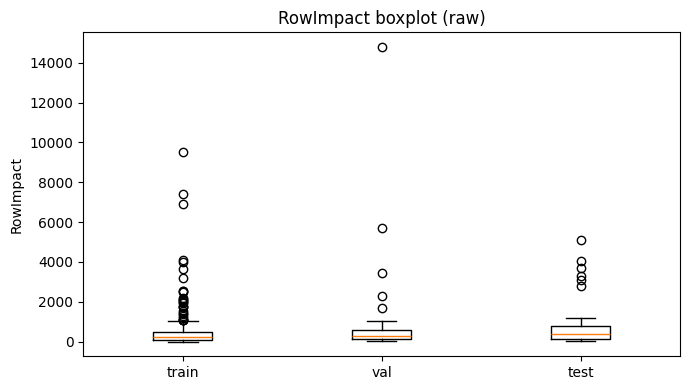

/tmp/ipykernel_25847/2065431220.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_log, labels=labels, showfliers=True)


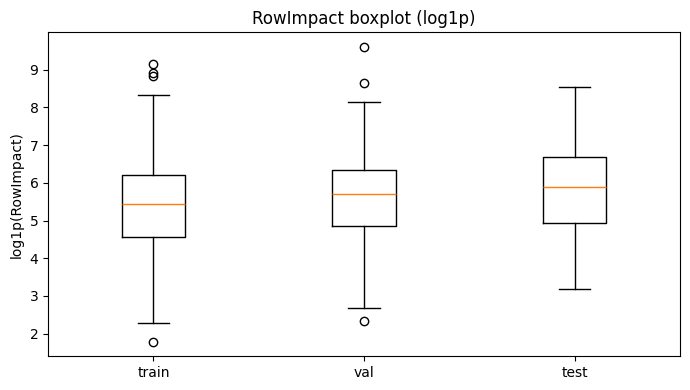

In [94]:
import numpy as np
import matplotlib.pyplot as plt

def boxplot_rowimpact(train_df, val_df, test_df=None, col="RowImpact"):
    data = [train_df[col].dropna().values, val_df[col].dropna().values]
    labels = ["train", "val"]

    if test_df is not None:
        data.append(test_df[col].dropna().values)
        labels.append("test")

    # --- raw ---
    plt.figure(figsize=(7,4))
    plt.boxplot(data, labels=labels, showfliers=True)
    plt.title("RowImpact boxplot (raw)")
    plt.ylabel("RowImpact")
    plt.tight_layout()
    plt.show()

    # --- log1p (recommended for heavy tails) ---
    data_log = [np.log1p(d) for d in data]
    plt.figure(figsize=(7,4))
    plt.boxplot(data_log, labels=labels, showfliers=True)
    plt.title("RowImpact boxplot (log1p)")
    plt.ylabel("log1p(RowImpact)")
    plt.tight_layout()
    plt.show()

# ---- run ----
boxplot_rowimpact(train_df, val_df, test_df, col="RowImpact")


Here’s a **max-5-point** summary of what your **RowImpact (Weighted-SST proxy)** plots + quantiles are telling you:

1. **All splits are extremely right-skewed** (histograms + boxplots): most rows have low RowImpact, and a *small number* of rows contribute very large RowImpact (long tail). This is exactly what you’d expect from a “score-critical” proxy.

2. **Validation looks systematically “easier” than train/test (lower typical + lower tail)**:

   * Median: **val ~175** vs **train ~291**, **test ~233**
   * 90th: **val ~533** vs **train ~1214**, **test ~1414**
   * 95th: **val ~676** vs **train ~2442**, **test ~2871**
     So val contains fewer high-impact rows overall.

3. **Test has the heaviest tail (hardest split in the extremes)**:
   At the 99th percentile **test ~7826** is much larger than **train ~5652** and **val ~2798**. That means test includes more “score-critical” extreme rows than train/val.

4. **A few outliers dominate the tail behavior** (visible as isolated points in boxplots and far-right bins in histograms). With **val/test being small**, a single extreme row can noticeably shift the tail quantiles and make split-to-split comparisons look more different than they “truly” are.

5. **Implication for the stability check (D)**: your splits are **not perfectly matched** in RowImpact difficulty—**val is lighter**, **test is heavier**. That doesn’t mean the split is “wrong”, but it *does* mean you should expect **validation to be noisier / potentially optimistic**, and the leaderboard/test behavior can feel harsher because more tail rows landed there.



In [95]:


from pathlib import Path

def save_split_df(df, out_dir='dataset/', mode="train", filename=None, overwrite=False):
    """
    Saves the given df as a parquet in out_dir.

    - mode: "train" | "val" | "test" (used for default filename)
    - filename: optional explicit filename (e.g., "train_df.parquet")
    - Does NOT modify df. Just saves it.
    """
    mode = str(mode).lower()
    if mode not in {"train", "val", "test"}:
        raise ValueError(f"mode must be one of {{'train','val','test'}}, got: {mode}")

    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    if filename is None:
        filename = f"{mode}.parquet"

    path = out_dir / filename

    if path.exists() and not overwrite:
        raise FileExistsError(f"{path} already exists. Set overwrite=True to replace.")

    df.to_parquet(path, index=False)
    print(f"Saved {mode} df -> {path}")
    return path


# images_root_dir = "/kaggle/input/csiro-biomass-images/"
data_root_dir   = "/kaggle/input/csiro-biomass-data1/"

save_split_df(train_df, out_dir=data_root_dir, mode="train", overwrite=True)
save_split_df(val_df,   out_dir=data_root_dir, mode="val",   overwrite=True)
save_split_df(test_df,  out_dir=data_root_dir, mode="test",  overwrite=True)

Saved train df -> /kaggle/input/csiro-biomass-data1/train.parquet
Saved val df -> /kaggle/input/csiro-biomass-data1/val.parquet
Saved test df -> /kaggle/input/csiro-biomass-data1/test.parquet


PosixPath('/kaggle/input/csiro-biomass-data1/test.parquet')